# Optimal parameters of limit orders in high frequency market making strategy

THESIS REPORT
***

## Abstract

We conisder problem of providing two-side quotes on financial markets (market-making or dealing). Problem is actual mostly for institutions who have obligations to support quotes for some instruments (liquidity provider) by placing bid and ask limit orders into limit order book (also known as Depth of Market). Dealer usually has to support both sides simulteneously during main trade session (full or part) with limit on maximum spread. The question is at what prices market-maker should place limit orders to maximize expected utility (profits) and minimize risks.

From theoretical point of view it is stochastic optimal control problem and it is studies a lot starting from 1980s. Optimal strategy heavily depends on market microstructure properties and there are rather simple solutions in some cases. In this work we investigate market microstructure properties and test one realization of such market-maker strategy for Russian currency market (USD/RUB). We test this strategy and compare it with simplest possible strategy, when dealer places order at constant distance from mid price.

__Key words:__ market-making, dealing, optimal pricing strategy, high-frequency trading.

Source code of the project is available on GitHub:
https://github.com/rasharp/FinalMDS

***

<a id="Content"></a>
## Table of Content

1. [Introduction](#Introduction)
1. [Chapter I. Task definition and theretical issues](#Task-def)
    1. [Avellaneda-Stoikov model](#AS-model)
    2. [Simple equidistant strategy](#EQ-model)
1. [Chapter II. Market research](#Market)
    1. [Preprocess data](#Preprocessing)
    2. [Volume distribution](#Volume-dist)
    3. [Price impact](#Price-impact)
    4. [Market volatility](#Volatility)
    5. [Other market parameters](#Others)
    6. [Summary](#Summary-1)
1. [Chapter III. Simulations](#Simulations)
    1. [Simple base model](#Base)
    2. [Simple base model for USDRUB](#Base-USDRUB)
    3. [Historical simulation](#Historical)
    4. [Advanced simulation](#Generator)
1. [Conclusions and further plans](#Conclusions)
1. [References](#References)
1. [Appendix A. Preprocessing source code](#Appendix-a)
1. [Appendix B. Tail exponent source code](#Appendix-b)
1. [Appendix C. Base simulations source code](#Appendix-c)
1. [Appendix D. Advanced simulations source cose](#Appendix-d)
1. [Appendix E. Order book generator source code](#Appendix-e)

***

## Introduction

In financial market dealer or market-maker (in this work we consider both this terms as synonyms) provides liquidity by quoting two-side limit orders (bid and ask) at which they is willing to buy (bid) or sell asset. Even in order-driven markets often there are participant who tries to trade on spread. Key issue here that dealer is ready to trade immediately any side without long-term preferences in direction. It differs them from short-term trader and investors who makes bet on some price direction. Profit arises when market-maker trades a lot of deals without strong directed price movement. So, the key risk of dealer is having too big position (inventory) in asset at the moment when adverse price movement happens (e.g. price falling having a lot of stocks). It is so-called inventory risk and we focus on it in this work. Another kind of risk is assymetric information risk arising from informed participants and it is not considered here.

Prices are changing extremely quickly. For liquid assets exchange process dozens of limit and market orders a second. So, dealer have to react on this condition changes otherwise it. Such trading called high-frequency trading. Strategies considered here are such kind. We don't consider technical issues of implementation such strategies in real-market conditions (it requires special low-latency infrastructure) and confine research to simulations on generated and historical data.

We consider single dealer market who trades single stock. The generalization to many assets is straightforward and basically not difficult. We consider strategies when dealer is always "in market", i.e. they has obligations to quote two-sides permanently. This obligation is quite natural: ETFs on Russian market usually has obligations for liquidity providers to quote both sides with limitation on time and maximum spread. See, for example, [Sberbank SBMX fund management rules](https://www.sber-am.ru/upload/iblock/fa6/fa603713f999f99279744b5f2bc51053.pdf). The logical consequence of such requirements is simple spread strategy, which is quite natural behchmark for this reason. In this strategy dealer places limit orders equidistantly from current mid price. Distances are constant and equal for bid and ask. So, the only task is fresh bid and ask prices in time. We use this strategy as a benchmark. Our goal here is to construct and test a more complicated strategy and compare it with this simplest one.

We suppose several light simplifications:
- dealer always has sufficient cash to satisfy collateral requirements.
- we don't consider problem of definition "true" or fair value of the asset. Here we assume mid price fair.
- only intraday interval of strategy. It is rather realistic, because most dealer prefer set inventory to zero before market closing (the only exception is FOREX which trades continuously 5 days a week).
- logical consequence of previous point: we don't take into account risk-free rate on cash, because we don't trade over night. Also we doesn't consider inventory return like dividends.
- we don't consider transaction costs here. Market-makers usually has very cheap cost for transaction as key institutional participants of the financial markets. But it is the interesting point for further analysis.

One of the main problem for any HFT strategy is testing. Order book data consume a lot of space and are not so accessible as price data. It makes historical test space consuming and slow. Obvious solution here is data generation. One more benefit from this approach is possibility to assess statistical properties of strategy. We use two different approach to simulation besides usual historical backtest.


Work is structured following way: in chapter I we consider one formalism for quasi-optimal market-maker strategy. Also we formulate simplest equidistant dealer strategy which is a benchmark. In chapter II we provide market microstructure research necessary to implement and test strategies for USD/RUB Moscow exchange market. In chapter III we perform several types of simulation and compare strategies results.

[To the top](#Content)
***

<a id="Task-def"></a>
## Chapter I. Task definition and theoretical issues

We need to introduce some notation to go further. Consider regular limit order book (or depth of market): 
<img src="doc/lob.png">

There are limit orders to buy (bids) and to sell (asks). When exhange gets market order it match it with limit orders and deals happen. On image above dealer's limit orders are easily distinguishable.

We denote current mid price (or briefly _mid_) as $s_t$. Dealer prices for limit orders we denote as $p_b$ for bid limit order and $p_a$ for ask limit order. Also it is convinient to introduce distances from mid: $\delta_b = mid - p_b$ and $\delta_a = p_a - mid$. Here we implicitly suppose that dealer prices are worse than best bid and ask almost always.

We consider mid price as stochastic process that follows Brownian motion: $dS = \mu dt + \sigma dZ$ (see assumptions below). We don't consider how market price execution affects mid price (so-called temporal price impact), for simplicity we consider mid price evolving as independent process.

Current inventory (position) and current cash are denoted as $q_t$ and $x_t$ accordingly. Current wealth of the dealer therefore is $W_t = x_t+q_t s_t$. In common words our goal is to maximize some utility function of final wealth.

As virtual price impact or simply _price impact_ we call the maximum price shift during market order execution: 
$$
\Delta p = |\text{best execution price} - \text{worst execution price}|
$$

We don't consider partial execution of orders in this work and it is significant simplification. If price impact $\Delta_p$ is greater than limit order distance $\delta$ we treat it as filled. We assume that market orders will fill our limit orders with some Poisson intensity $\lambda$ which obviously depends on order price distance $\delta$. The further order placed the rarely it will be filled. We denote these intensities (also caled _arrival rates_) as $\lambda_b(\delta_b)$ and $\lambda_a(\delta_a)$ for bid and offer orders accordingly. Moreover, use assume these Poisson processes stable in time (intensities doesn't change for a time horizon).

Task here is to find the optimal way to set limit order in the process of market-making. Here we consider a formalism of this process: simple utility maximization strategy introduces in [[Avellaneda, Stoikov 2008]](#References). A very brief explanation of the model is provided below.

In this research we consider this strategy in more details. The goals of this research are
- approve model applicability for Russian currency market (USD/RUB currency pair), i.e. check for model assumptions;
- estimate market microstructure parameters;
- test model on historical and generated data;
- compare results with benchmark strategy;

<a id="AS-model"></a>
### 1. Avellaneda-Stoikov model

#### I. Brief model description

Firstly, we introduce expected exponential utility $U(W_t) = E[-e^{-\gamma*W_t}]$, where $\gamma$ is risk aversion of the dealer. The goal (optimal performance function) is maximize final expected utility by control distances $\delta_b$ and $\delta_a$:
$$
J(x, q, s, t) = \max_{\delta_b, \delta_a} E[-e^{-\gamma*W_T}]
$$
where $T$ is time-horizon of the strategy.

As it is shown in [[Ho, Stoll 1981]](#References) and [[Davis 1977]](#References), this task can be reformulated in terms of dynamic programming (Hamilton-Jacobi-Bellman equation):
$$
J_t + J_s \mu_s s + \frac{1}{2} J_{ss} \sigma_s^2 s^2
+ \max_{\delta_b}\lambda^b(\delta_b)[J(x-s+\delta_b, q+1, s, t)-J(x,q,s,t)]\\
+ \max_{\delta_a}\lambda^a(\delta_a)[J(x+s+\delta_a, q-1, s, t)-J(x,q,s,t)] = 0
\\
J(x,q,s,T) = U(W_T)
$$

Next key issue is an assumption about decomposition of utility function: $U(x, q, s, t) = -e^{-\gamma x}e^{-\gamma\theta(q, s, t)}$ for some $\theta$. It should be notices that it is only relevant in case of simple Brownian motion (not geometric). So, we obtain partial derivative equation that doesn't depend on cash $x$ and it is rather logical (market order parameters depend only on inventory):

$$
\frac{\partial \theta}{\partial t} +  \mu \frac{\partial \theta}{\partial s} + \frac{1}{2}\sigma^2 \big(\frac{\partial^2 \theta}{\partial s^2}-\gamma(\frac{\partial \theta}{\partial s})^2\big) + 
\frac{1}{\gamma} \max_{\delta_b} \big[\lambda^b(\delta_b)(1-e^{-\gamma(r_b-p_b)})\big] +
\frac{1}{\gamma} \max_{\delta_a} \big[\lambda^a(\delta_a)(1-e^{-\gamma(p_a-r_a)})\big] = 0
\\
\theta(q,s,T) = qs
$$

Here $p_a$ and $p_b$ are ask and bid prices of limit orders.
$r_b$ and $r_a$ are so-called reservation prices:

$$r_b = \theta(q+1,s,t)-\theta(q,s,t) \\ r_a = \theta(q,s,t)-\theta(q-1,s,t)$$
The meaning is the following: reservation prices are prices of dealer indifference to invetory changing. For example, definition for bid reservation price is $U(x,q,s,t) = U(x-p_b, q+1, s, t)$.

Using first-order optimality condition for max expressions in PDE above we can obtain following equations for $\delta_b$ and $\delta_a$:
$$
s - \delta_b = r_b - \frac{1}{\gamma} \log \big( 1 - \gamma 
    \frac{\lambda^b(\delta_b)}{\frac{\partial \lambda^b}{\partial \delta_b}(\delta_b)}\big) \\
s + \delta_a = r_a + \frac{1}{\gamma} \log \big( 1 - \gamma 
    \frac{\lambda^a(\delta_a)}{\frac{\partial \lambda^a}{\partial \delta_a}(\delta_a)}\big)
$$

#### II. Assumptions of the model

To solve mentioned above PDE we need some simplifications and assupmtions about market microstructure to estimate $\lambda^a(\delta_a)$ and  $\lambda^b(\delta_b)$.

__a. Brownian motion__ of prices

$$
dS = \mu dt +\sigma dZ
$$
As metioned above, we consider simple Brownian motion instead of geometric. For very short intervals like several hours or a day it is not crucial whether geometric or simple Brownian motion to use, but the last one is simplier.

__b. Volume distribution__ follows power law.

Distribution of market and limit order size are well studied. See, for example [[Gopikrishnan et al. 2000]](#References), [[Gabaix, X. 2006]](#References) and [[Maslow, Mills 2001]](#References). Consensus here is that market order size obeys power law. Distribution of limit order sizes is not so clear and seems follows log-normal distribution, see also [[Maslow, Mills 2001]](#References). Model assumption for density of market order size is

$$ f_V(x) \propto x^{-(\alpha+1)} $$

where $\alpha$ is so-called tail exponent.

__c. Price impact__ on average is proportional to log of volume of market order.

There are several studies of price impact like [[Potters, Bouchaud, 2003]](#References) and [[Weber, P. and Rosenow, B. 2003]](#References). They focused mostly on temporal structure of impact. There are no consensus about price impact dependency on volumes but there are two hypothesis: $\Delta p \propto V^{-\beta}$ and $\Delta p \propto \log V$. 

Exhaust research of price impact from theoretical point of view for different types of participants (regular and large investors) is provided in [[Gabaix, X. 2006]](#References), where  estimation for $\beta$ are __0.5__ for regular and __1__ for large investors are obtained.


In Avellaneda-Stoikov model the logarithmic one is supposed.

__d. Intensity of market orders is constant__. We consider market order event as Poisson process with constant intensity. 
This assumption is not true in strict sence, but for short time horizon it is not so implausble. We denote intensity as $\Lambda$ and not differ intensity for buy and sell orders for simplisity.

Using this assumptions, intensities (arrival rates) for buy and sell market orders are
$$\lambda(\delta) = \Lambda P(\Delta p > \delta)=\frac{\Lambda}{\alpha}e^{-\alpha\delta/K} = A e^{-k\delta}
$$
Here $A=\Lambda / \alpha$ is intensity parameter and $k=\alpha/K$ is sensitivity to spread.


__e.__ __Quadratic asymptotic expansion for__ $\theta(q,s,t)$ (Taylor series):
$$
\theta(q,s,t) = \theta_0(s,t) + \theta_1(s,t)q + \frac{1}{2} \theta_2(s,t)q^2
$$

Using all above assumptions it is possible to simplify PDE and find analytical solution.

#### III. Solution

Avellaneda-Stoikov model (AS-model) PDE solution under this assumptions is:
$$
\theta_1 = s + \mu(T-t)\\
\theta_2 = -\sigma^2\gamma(T-t)
$$
Optimal spread is
$$
\delta_b+\delta_a = -\theta_2(s,t)+\frac{2}{\gamma}\log(1+\frac{\gamma}{k}) = \sigma^2 \gamma (T - t)+\frac{2}{\gamma}\log(1+\frac{\gamma}{k})
$$

which is around the mid reservation price: 
$$
r{\text-}price = \frac{r_b+r_a}{2} =\theta_1(s,t)+\theta_2(s,t)q = s + \mu(T-t)- \sigma^2 \gamma (T - t)q
$$

Optimal bid and ask prices are $p_b = r{\text-}price-(\delta_b+\delta_a)/2$ and $p_b = r{\text-}price+(\delta_b+\delta_a)/2$.




[To the top](#Content)
***

<a id="EQ-model"></a>
### Simple equidistant strategy

In this strategy we put order on some constant equal distant from the current mid. Mathematically it is rather simple - use constant spread around the mid price:
$$ \delta _a + \delta_b = const \\r{\text -}price = mid$$

Optimal bid and ask prices are the same: $p_b = r{\text-}price-(\delta_b+\delta_a)/2$ and $p_b = r{\text-}price+(\delta_b+\delta_a)/2$.


[To the top](#Content)
***

<a id="Market"></a>
## Chapter II. Market research

We need to check model assumptions and estimate market microstructure parameters. In this section we provide some research for [USD/RUB](https://www.moex.com/ru/issue/USD000UTSTOM/CETS) currency pair traded on [Moscow Exchange](https://moex.com). 

Assumptions have to be checked:
- distribution of volumes follow power law
- logarithmic relationship between average price impact and order size 


If assumptions are true, we need to estimate parameters:
- power law tail exponent $\alpha$
- logarithmic regression slope coefficient $K$
- intensity of market orders $\Lambda$
 

<a id="Preprocessing"></a>
### Preprocessing data

Preprocessing consists of three steps:
1. grouping deals to market order with price impact calculation (using deals table)
2. add info about bid and ask prices at deal moment (using LOB history files) for historical simulation
2. add features for further analysis and filtering

All preprocessing procedure is consolidated in ```Preprocessing.ipynb``` and ```preprocess.py``` and available on [GitHub](https://github.com/rasharp/FinalMDS) (see also [Appendix A](#Appendix-a) for source code) 

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm 
import statsmodels.formula.api as smf

In [2]:
# example of the raw data
data = pd.read_feather('Data/USDRUB_TOM_trades.feather')

In [3]:
data[:5]

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
0,2021-02-01 10:00:00.271880,75.5975,100,B,7559750.0
1,2021-02-01 10:00:00.271880,75.6000,500,B,37800000.0
2,2021-02-01 10:00:00.271880,75.6700,63,B,4767210.0
3,2021-02-01 10:00:00.304507,75.6625,10,B,756625.0
4,2021-02-01 10:00:00.346729,75.6575,3,B,226972.5


I preprocessed data only once and then load preprocessed data.
Data available on Google drive by [direct link](https://drive.google.com/file/d/1qQbd4jdnQLMjaFsJ82Vrs45H92hLRpjc/view?usp=sharing)

In [4]:
# load preprocessed data
market_orders = pd.read_feather('market_orders_USDRUB.feather')

In [5]:
# preprocessed data
# DOW is Day of Week (1 is Monday)
# H is Hour
# Impact = PRICE_max - PRICE_min
# SIZE_sum == Volume
market_orders[:5]

,Time,AGGRESSOR_SIDE,PRICE_min,PRICE_max,SIZE_sum,Date,TimeOnly,DOW,H,Impact,BID,ASK,MID,Spread
0,2021-02-01 10:00:00.271880,B,75.5975,75.6700,663,2021-02-01,10:00:00.271880,1,10,0.0725,75.565002,75.599998,75.582504,0.0350
1,2021-02-01 10:00:00.304507,B,75.6625,75.6625,10,2021-02-01,10:00:00.304507,1,10,0.0000,75.567497,75.662498,75.614998,0.0950
2,2021-02-01 10:00:00.346729,B,75.6575,75.6575,3,2021-02-01,10:00:00.346729,1,10,0.0000,75.602501,75.657501,75.630005,0.0550
3,2021-02-01 10:00:00.360369,S,75.6025,75.6025,20,2021-02-01,10:00:00.360369,1,10,0.0000,75.602501,75.625000,75.613754,0.0225
4,2021-02-01 10:00:00.377261,S,75.6025,75.6025,4,2021-02-01,10:00:00.377261,1,10,0.0000,75.602501,75.639999,75.621246,0.0375


[To the top](#Content)
***

<a id="Volume-dist"></a>
### Market order volume distribution

Trsde session for USDRUB_TOM instrument on MOEX is quite long: from 07:00 till 23:00. But most active hours are from 10:00 (historical open time) till 17:45 (TOD session closing). Therefore we filter data for these most active trade hours (from 10:00 till 17:59):

In [6]:
# Filter for workday and main trade session
df = market_orders[(market_orders['DOW'] <= 5) &
                   (market_orders['H'] >= 10) &
                   (market_orders['H'] <= 17)]

(0.0, 100000.0)

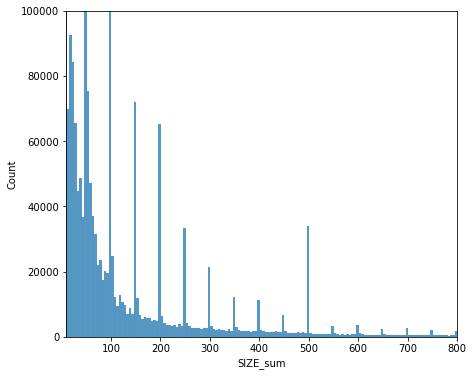

In [33]:
# Volumes distributionб ишт цшвер = 10
plt.figure(figsize=(7, 6))
ax = sns.histplot(data=df, x='SIZE_sum', binwidth=5)
ax.set_xlim([10, 800])
ax.set_ylim([0, 100000])

It is easy to notice peaks of volumes multiple by 50K (in range 50-1000). Also there are peaks at 1000, 2000, 2500, 3000 and 5000 lots. I suppose volumes consist of three component:
- non-rounded lots caused by regular participants $V_r$
- medium size rounded to 50 (x50) which caused by medium-size institutions $V_{x50}$
- large size rounded to 500/1000 (x500) which caused by big institutions $V_{x500}$

$$\text{Total count for } V = V_r + V_{x50} + V_{x500} $$

This structure of distribution make analysis a bit complicated. We need to decompose distribution into parts. For this we used rather simple smoothing technique:
1. to estimate "true" regular volumes count $V_r$ for x50 orders simple average of neighbors is used: $ V_r(50x) = (V_r(50x-1) + V_r(50x+1))/2 $
2. extra counts for x50 orders is "true" $V_{x50}$ volume
3. same procedure is performed for $V_{x50}$ vs $V_{x500}$ volumes

In [35]:
# 1. group data into bins with width = 10 for probability density function (PDF) calculation
dfv = df.copy() 
vbins = np.arange(0, 15010, 10)  # bins
dfv['VolBin'] = pd.cut(df['SIZE_sum'], vbins)  # add bin category feature
dfv = dfv[['VolBin', 'SIZE_sum']].groupby(by='VolBin', as_index=True).agg({'SIZE_sum': ['sum', 'count']})  # group

In [36]:
# rename multicolumns
dfv.columns = ['Sum', 'Count']  # rename and flatten columns
dfv.index = dfv.index.map(lambda vb: vb.right)  # set index = right bin border

In [37]:
# 2. SMOOTHING regular volumes: exclude x50 extra volumes by using average of neighbors. 
#    Obtains new PDF for regular volumes and x50 volumes like this:
dfv['VC'] = dfv['Count']
dfv['VD1'] = 0.
# bins with x50 volumes 
for i in range(50, 10000, 50): 
    # calculate average on neighbor bins
    z = min(float(dfv.loc[i, 'VC']), float(dfv.loc[i-10, 'VC'] + dfv.loc[i+10, 'VC'])//2)
    dfv.loc[i, 'VD1'] = float(dfv.loc[i, 'VC'] - z)
    dfv.loc[i, 'VC'] = z

In [38]:
# 3. SMOOTHING x50 volumes: same procedure for x500 volumes, extract them to separate column of PDF
dfv['VD2'] = 0.
# bins with x500 volumes 
for i in range(500, 10000, 500):
    z = min(float(dfv.loc[i, 'VD1']), float(dfv.loc[i-50, 'VD1'] + dfv.loc[i+50, 'VD1'])//2)
    dfv.loc[i, 'VD2'] = float(dfv.loc[i, 'VD1'] - z)
    dfv.loc[i, 'VD1'] = z

In [39]:
# Here VolBin is order size bin
# VC is regular orders statistic (count)
# VD1 is x50 orders statistic
# VD2 is x500 orders statistic
dfv[:5]

,Sum,Count,VC,VD1,VD2
VolBin,,,,,
10,3676319,1004822,1004822,0.0,0.0
20,2682247,162610,162610,0.0,0.0
30,3820411,149834,149834,0.0,0.0
40,3355862,93515,93515,0.0,0.0
50,39074118,788221,108081,680140.0,0.0


There are plenty of method for tail exponent estimation. Usually Hill's estimator is used:
$$
\alpha(k) = k \big[\sum_{j=1}^{k}{\log\frac{x_{N-j+1}}{x_{N-k}}} \big]
$$
Method is quite sensitive to start index k, and as it is shown in [[ I.I. Komarov, H.L. Chen.]](#References) it works well mostly for exponent less than 1.5. 
Exhaustive review of tail index estimation method is provided in [[Munasinghe, R. et al., 2020]](#References). Some method we used (and implemented in ```tail_index.py``` (see also [Appendix B](#Appendix-b)):
- Maximum likelihood (MLE)
- Weighted Least squares (WLS)
- Percentile (PM)
- Method of moments (MoM)

We used method of plotting linear regression of complement cumulative distribution function (see for example [[Maslow, Mills 2001]](#References)):
$$ CCDF(V) \propto V^{-\alpha} $$

In log-log scale it is simply linear regression:
$$ \log CCDF(V) = -\alpha \log V + c $$

Let's estimate tail index for all data:

Huge volumes are traded by orders with size 50K, 100K, 500K and 1000K.

In [40]:
# regression of CCDF in log-log coordinates
reg_range = [200, 5000]  # range for regression, only tail
ccdf = 1. - np.cumsum(dfv['Count'])/np.sum(dfv['Count'])  # complement cdf = 1 - cdf

dxy = pd.DataFrame({'X': dfv.index.to_numpy(), 'Y': ccdf})  # temp DataFrame for statsmodels
dxyr = dxy[(dxy.X >= reg_range[0]) & (dxy.X <= reg_range[1])]  #
model = smf.gls('np.log(Y) ~ np.log(X)', data=dxyr)  # linear regression
res = model.fit()
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:              np.log(Y)   R-squared:                       0.990
Model:                            GLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 4.916e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:44:02   Log-Likelihood:                 234.98
No. Observations:                 481   AIC:                            -466.0
Df Residuals:                     479   BIC:                            -457.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2368      0.070    132.076      0.0

Determination coefficient is high enough, regression is overally significant. So, tail exponent $\alpha$ is close to __2.0__. Plot of the regression:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='X', ylabel='Y'>

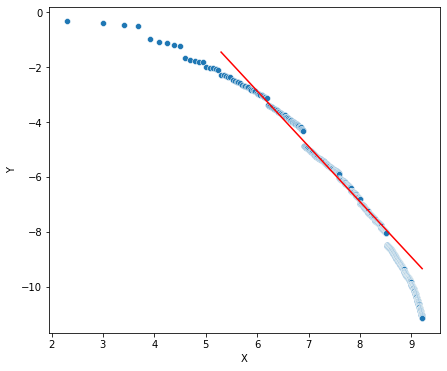

In [44]:
# plot
linreg = lambda x: res.params[0] + res.params[1]*x  # linear regression function
reg_range = [200, 10000]

plt.figure(figsize=(7, 6))
sns.scatterplot(np.log(dxy.X), np.log(dxy.Y))
sns.lineplot(np.log(reg_range), linreg(np.log(reg_range)), color='r')

Let's try to estimate tail exponent separately for components: for rounded x50 volumes and regular volumes:

Text(0.5, 1.0, 'PDF for x50 volumes')

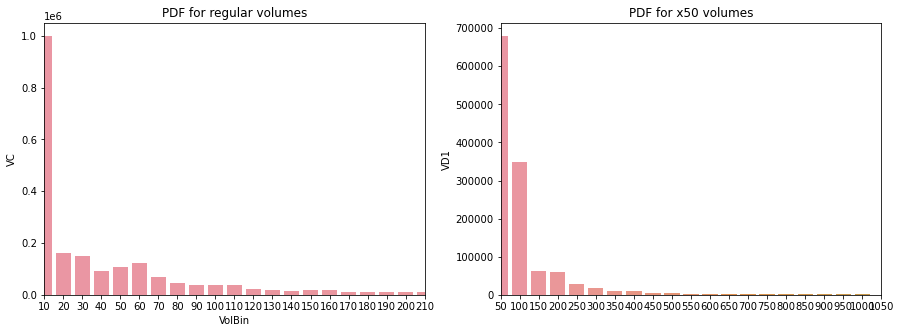

In [15]:
# Distributions of volumes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=dfv.index, y=dfv.VC, ax=ax[0])
ax[0].set_xlim([0, 20])
ax[0].set_title("PDF for regular volumes")

sns.barplot(x=dfv[dfv.VD1!=0].index.to_numpy(), y=dfv[dfv.VD1!=0].VD1, ax=ax[1])
ax[1].set_xlim([0, 20])
ax[1].set_title("PDF for x50 volumes")

In [16]:
# estimate tail indexes for this sub-PDF
reg_range = [200, 5000]  # range for regression, only tail
ccdf_vc = 1. - np.cumsum(dfv['VC'])/np.sum(dfv['VC'])  # complement cdf = 1 - cdf
ccdf_vd = 1. - np.cumsum(dfv['VD1'])/np.sum(dfv['VD1'])

dxy_vc = pd.DataFrame({'X': dfv.index.to_numpy(), 'Y': ccdf_vc})  # temp DataFrame for statsmodels
dxy_vd = pd.DataFrame({'X': dfv.index.to_numpy(), 'Y': ccdf_vd})

dxyr_vc = dxy_vc[(dxy_vc.X >= reg_range[0]) & (dxy_vc.X <= reg_range[1])]  # limit regression range
dxyr_vd = dxy_vd[(dxy_vd.X >= reg_range[0]) & (dxy_vd.X <= reg_range[1])]

model = smf.gls('np.log(Y) ~ np.log(X)', data=dxyr_vc)  # linear regression for regular volumes
res_vc = model.fit()
print("\n\nRegression for regular volumes:")
print(res_vc.summary())

model = smf.gls('np.log(Y) ~ np.log(X)', data=dxyr_vd)  # linear regression for x50 volumes
res_vd = model.fit()
print("Regression for x50 volumes:")
print(res_vd.summary())



Regression for regular volumes:
                            GLS Regression Results                            
Dep. Variable:              np.log(Y)   R-squared:                       0.992
Model:                            GLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 6.248e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:35:52   Log-Likelihood:                 305.33
No. Observations:                 481   AIC:                            -606.7
Df Residuals:                     479   BIC:                            -598.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8

Seems x50 component has heavier tails. Both regressions are significant with high determination coefficient.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwar

Text(0.5, 1.0, 'Tail exponent = -2.3048')

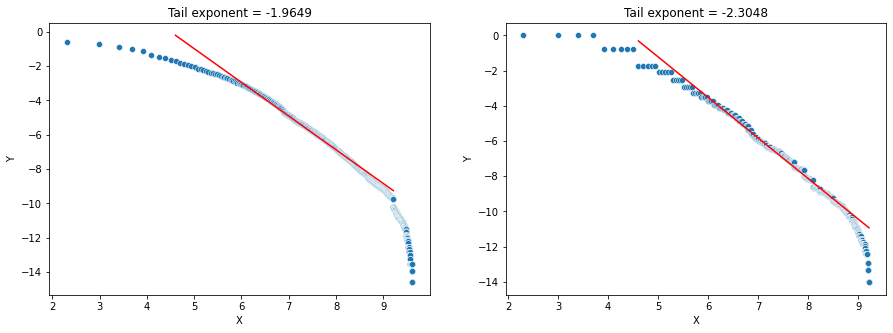

In [17]:
# plots
linreg_vc = lambda x: res_vc.params[0] + res_vc.params[1]*x  # linear regression regular volumes
linreg_vd = lambda x: res_vd.params[0] + res_vd.params[1]*x  # linear regression x50 volumes
reg_range = [100, 10000]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(np.log(dxy_vc.X), np.log(dxy_vc.Y), ax=ax[0])
sns.lineplot(np.log(reg_range), linreg_vc(np.log(reg_range)), color='r', ax=ax[0])
ax[0].set_title(f"Tail exponent = {res_vc.params[1]:0.4f}")

sns.scatterplot(np.log(dxy_vd.X), np.log(dxy_vd.Y), ax=ax[1])
sns.lineplot(np.log(reg_range), linreg_vd(np.log(reg_range)), color='r', ax=ax[1])
ax[1].set_title(f"Tail exponent = {res_vd.params[1]:0.4f}")

For model we used value $\alpha = 2.0$.

[To the top](#Content)
***

<a id="Price-impact"></a>
### Price impact

Now we check hypothesis of log dependency of price impact and try to estimate regression parameters. Remind that we need coefficient of regression
$$
\overline{\Delta p} = K \log V
$$

First of all let plot depenency of average price impact on volume of order. I use slide windowing to average volumes as well and additional filtering to exclude impact anomalies in data.

In [18]:
# Again I use same filters for workdays and hours, but also I limit volumes to exclude extra tail
# Also I exclude anomalies of impact
df = market_orders[(market_orders['Impact'] < 0.40) &
                   (market_orders['SIZE_sum'] > 0) &
                   (market_orders['SIZE_sum'] <= 10000) &
                   (market_orders['H'] >= 10) &
                   (market_orders['H'] <= 17)]

dfb = df[df['AGGRESSOR_SIDE']=='B']  # filter BUY market orders
dfs = df[df['AGGRESSOR_SIDE']=='S']  # filter SELL market orders

In [19]:
# Average impact on sliding window of volume
v_range = np.arange(10, 10000, 10)

window = 0.025  # 5% window 
avg = pd.Series([df[(df['SIZE_sum'] >= (1-window)*x) & (df['SIZE_sum'] <= (1+window)*x)]['Impact'].mean() 
        for x in v_range], index=v_range)

avgb = pd.Series([dfb[(dfb['SIZE_sum'] >= (1-window)*x) & (dfb['SIZE_sum'] <= (1+window)*x)]['Impact'].mean() 
           for x in v_range], index=v_range)

avgs = pd.Series([dfs[(dfs['SIZE_sum'] >= (1-window)*x) & (dfs['SIZE_sum'] <= (1+window)*x)]['Impact'].mean() 
           for x in v_range], index=v_range)

<AxesSubplot:>

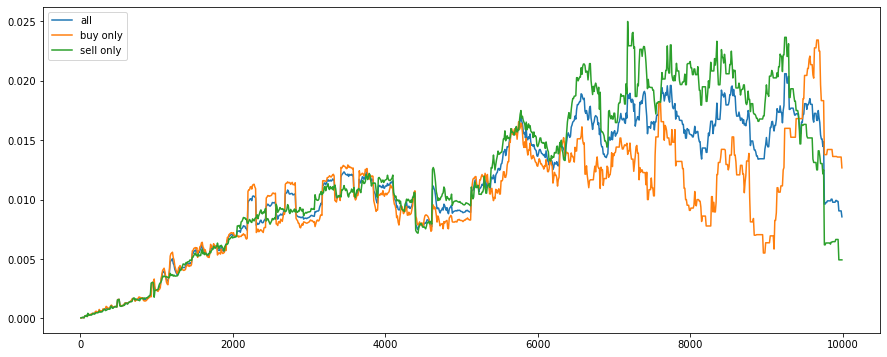

In [20]:
plt.figure(figsize=(15, 6))

sns.lineplot(x=v_range, y=avg, label='all')
sns.lineplot(x=v_range, y=avgb, label='buy only')
sns.lineplot(x=v_range, y=avgs, label='sell only')

Looks like linear for small volumes and logarithmic for larger ones. Let's check:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0.5, 1.0, 'Volume vs Impact, 800K+ USD')

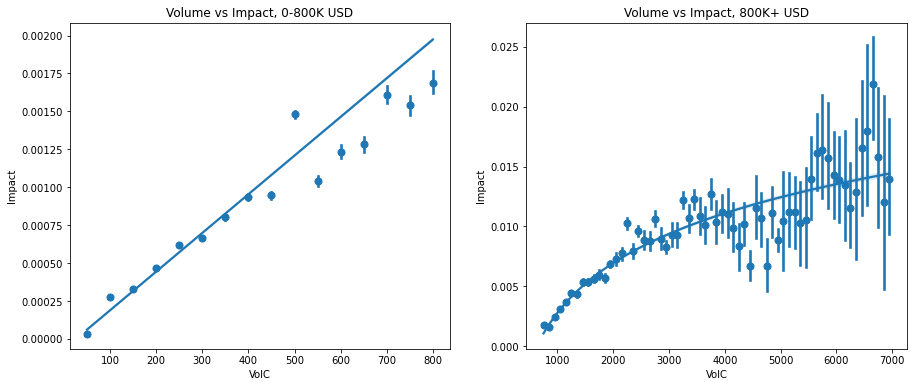

In [21]:
dfc = df[df['SIZE_sum'] <= 1000]
dfc.loc[:, 'VolC'] = pd.cut(dfc['SIZE_sum'], bins=np.arange(0, 1050, 50), labels=np.arange(50, 1050, 50))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.regplot(data=dfc[(dfc['SIZE_sum'] >= 0) & (dfc['SIZE_sum'] <= 800)], 
            x='VolC', y='Impact', x_estimator=np.mean, ax=ax[0])
ax[0].set_title("Volume vs Impact, 0-800K USD")

dfc = df[df['SIZE_sum']>=500]
dfc.loc[:, 'VolC'] = pd.cut(dfc['SIZE_sum'], bins=np.arange(500, 10100, 100), labels=np.arange(550, 10050, 100))
sns.regplot(data=dfc[(dfc['SIZE_sum'] >= 800) & (dfc['SIZE_sum'] <= 7000)], 
            x='VolC', y='Impact', x_estimator=np.mean, logx=True, ax=ax[1])
ax[1].set_title("Volume vs Impact, 800K+ USD")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0.5, 1.0, 'Volume vs Impact, 800K+ USD')

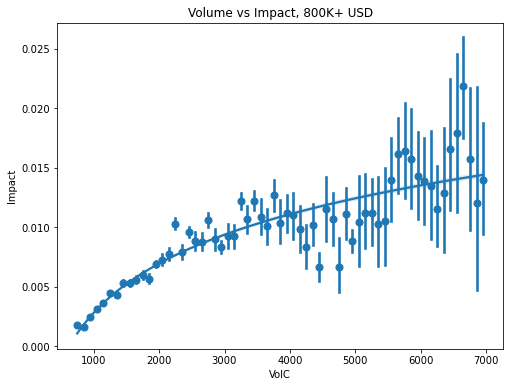

In [47]:
plt.figure(figsize=(8, 6))
dfc = df[df['SIZE_sum']>=500]
dfc.loc[:, 'VolC'] = pd.cut(dfc['SIZE_sum'], bins=np.arange(500, 10100, 100), labels=np.arange(550, 10050, 100))
sns.regplot(data=dfc[(dfc['SIZE_sum'] >= 800) & (dfc['SIZE_sum'] <= 7000)], 
            x='VolC', y='Impact', x_estimator=np.mean, logx=True)
plt.title("Volume vs Impact, 800K+ USD")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0.5, 1.0, 'Volume vs Impact, 800K+ USD')

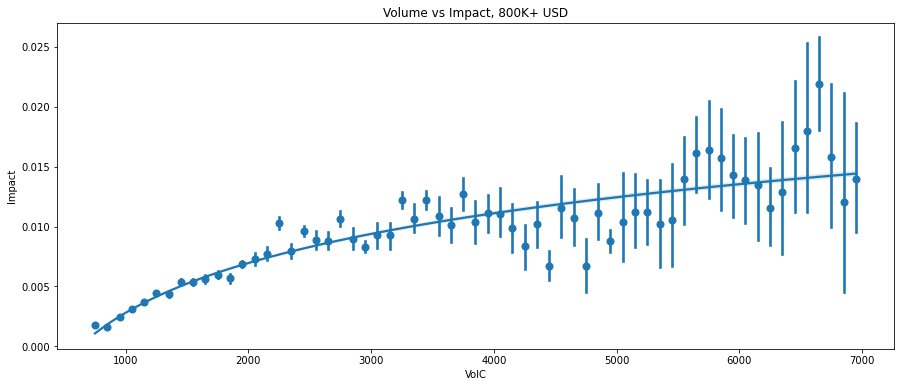

In [22]:
dfc = df[df['SIZE_sum']>=500]
dfc.loc[:, 'VolC'] = pd.cut(dfc['SIZE_sum'], bins=np.arange(500, 10100, 100), labels=np.arange(550, 10050, 100))

plt.figure(figsize=(15, 6))
sns.regplot(data=dfc[(dfc['SIZE_sum'] >= 800) & (dfc['SIZE_sum'] <= 7000)], 
            x='VolC', y='Impact', x_estimator=np.mean, logx=True)
plt.title("Volume vs Impact, 800K+ USD")

Let's look at regressions more closely:

Text(0.5, 1.0, 'Volumes 800k-8M')

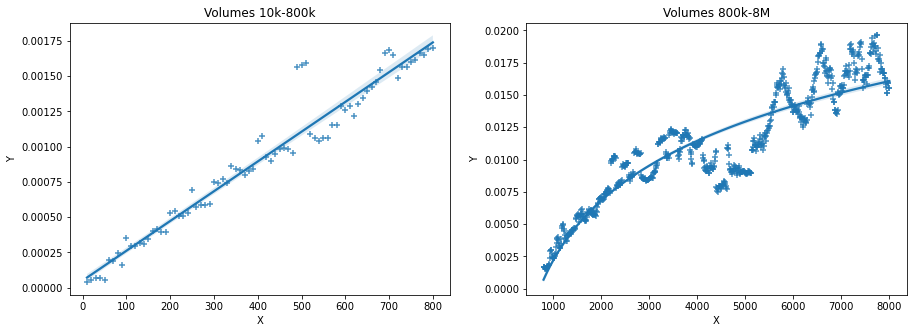

In [23]:
# Plots of regression average impact on volumes, only averages
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

X1 = v_range[(v_range>=10) & (v_range<=800)]
dxy1 = pd.DataFrame({'X': X1, 'Y': avg.loc[X1]})
sns.regplot(data=dxy1, x='X', y='Y', ax=ax[0], marker='+')
ax[0].set_title('Volumes 10k-800k')

X2 = v_range[(v_range>=800) & (v_range<=8000)]
dxy2 = pd.DataFrame({'X': X2, 'Y': avg.loc[X2]})
sns.regplot(data=dxy2, x='X', y='Y', logx=True, ax=ax[1], marker='+')
ax[1].set_title('Volumes 800k-8M')

In [24]:
model = smf.gls('Y ~ X', data=dxy1)
res1 = model.fit()
print("Regression (GLS) for low volumes (0-800k), linear, summary\n")
print(res1.summary())

Regression (GLS) for low volumes (0-800k), linear, summary

                            GLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.947
Model:                            GLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1387.
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           1.93e-51
Time:                        21:45:01   Log-Likelihood:                 611.64
No. Observations:                  80   AIC:                            -1219.
Df Residuals:                      78   BIC:                            -1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [25]:
model = smf.gls('Y ~ np.log(X)', data=dxy2)
res2 = model.fit()
print("Regression for high volumes (800k+), log linear, summary\n")
print(res2.summary())

Regression for high volumes (800k+), log linear, summary

                            GLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.819
Model:                            GLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     3250.
Date:                Thu, 23 Dec 2021   Prob (F-statistic):          6.28e-269
Time:                        21:45:01   Log-Likelihood:                 3514.3
No. Observations:                 721   AIC:                            -7025.
Df Residuals:                     719   BIC:                            -7015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Both regressions are significant with high enough determination coefficient.

So, coefficient $K$ is equal __0.0067__ and it is statistically sighnificant. Regression has high coefficient of determination $R^2 = 0.819$

Text(0.5, 1.0, 'Residuals, Volumes 800k-8M')

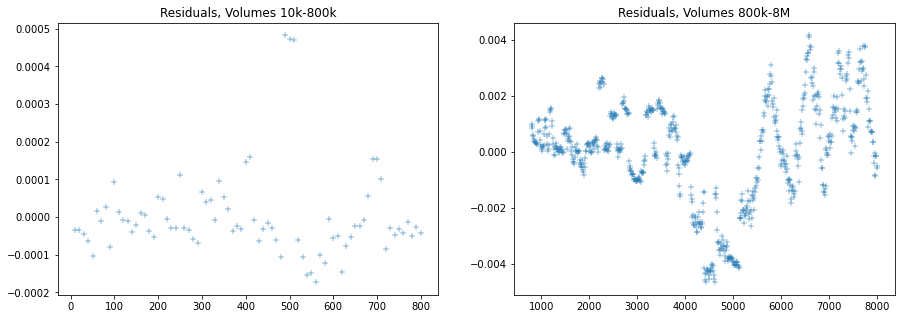

In [26]:
# Residuals of regressions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=X1, y=res1.resid, marker='+', ax=ax[0])
ax[0].set_title('Residuals, Volumes 10k-800k')
sns.scatterplot(x=X2, y=res2.resid, marker='+', ax=ax[1])
ax[1].set_title('Residuals, Volumes 800k-8M')

Text(0.5, 1.0, 'Residuals, Volumes 800k-8M')

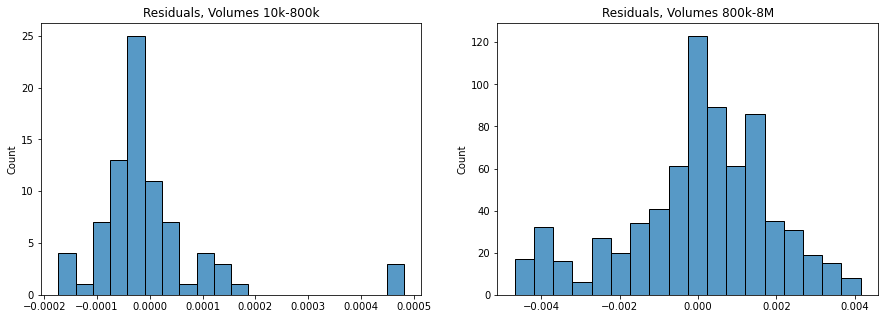

In [27]:
# Residuals of regressions distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=res1.resid, ax=ax[0])
ax[0].set_title('Residuals, Volumes 10k-800k')
sns.histplot(x=res2.resid, ax=ax[1])
ax[1].set_title('Residuals, Volumes 800k-8M')

Also I tried to estimate this dependency for x50 market orders only. Result is the same:

In [28]:
# Volumes to check
volx = np.concatenate([np.arange(0, 1000, 50),                          
                       np.arange(1000, 9500, 250)])

<AxesSubplot:xlabel='X', ylabel='Y'>

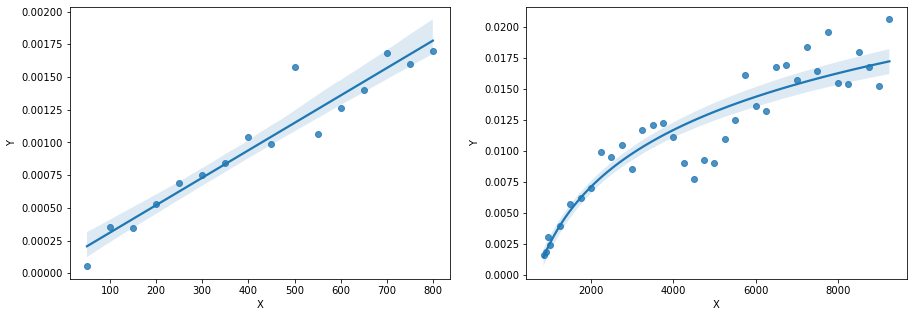

In [29]:
dxy = pd.DataFrame({'X': volx[1:], 'Y': avg.loc[volx[1:]]})

# Volumes 0-800K, linear region
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(data= dxy[dxy.X<=800], x='X', y='Y', ax=ax[0])

# Volumes 800+, logarithmic region
sns.regplot(data= dxy[dxy.X > 800], x='X', y='Y', logx=True, ax=ax[1])

In [30]:
model = smf.gls('Y ~ X', data=dxy[dxy.X<=800])
model.fit()
res = model.fit()
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.924
Model:                            GLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           3.21e-09
Time:                        21:45:02   Log-Likelihood:                 119.44
No. Observations:                  16   AIC:                            -234.9
Df Residuals:                      14   BIC:                            -233.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001   7.77e-05      1.309      0.2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [31]:
model = smf.gls('Y ~ np.log(X)', data=dxy[dxy.X>800])
model.fit()
res = model.fit()
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.860
Model:                            GLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     215.7
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           1.56e-16
Time:                        21:45:02   Log-Likelihood:                 178.95
No. Observations:                  37   AIC:                            -353.9
Df Residuals:                      35   BIC:                            -350.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0432      0.004    -11.566      0.0

Again regression is sighnificant with high determination coefficient. 
Slope is almost the same __0.0066__ and significant.

[To the top](#Content)
***

<a id="Volatility"></a>
### Market volatility

It is rather simple and standard procedure for market researches. Daily quotes for USDRUB_TOM (close prices) for period from Jan'2021 till Nov'20201 are used. I tried 

In [50]:
# Daily 
data_usd = pd.read_csv('USDRUB_TOM_D_202101-10.txt', sep=';')
data_usd[:5]

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<AMOUNT>,<VOLUME>
0,USDRUB_TOM,D,20210104,0,74.1350,74.4050,73.0550,74.3300,2196588000,1.617940e+11
1,USDRUB_TOM,D,20210105,0,74.1125,75.2875,73.8500,74.0400,2696328000,2.012427e+11
2,USDRUB_TOM,D,20210106,0,73.7800,74.2075,73.3975,73.9225,2002842000,1.477447e+11
3,USDRUB_TOM,D,20210108,0,74.2650,74.8350,73.8175,74.1550,2341573000,1.738605e+11
4,USDRUB_TOM,D,20210111,0,74.4325,75.0000,74.2650,74.6600,3943607000,2.942960e+11


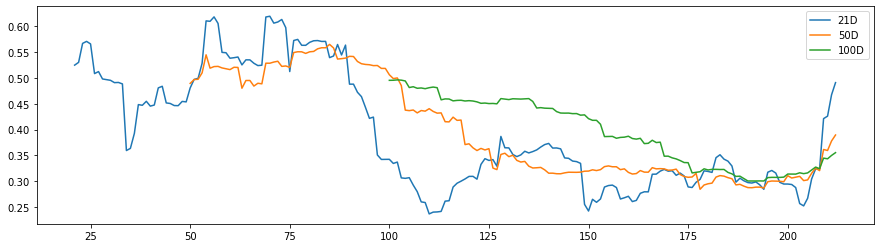

In [51]:
close_price = data_usd['<CLOSE>'].diff()
sigma = close_price.rolling(window=21).std()

plt.figure(figsize=(15, 4))
plt.plot(close_price.rolling(window=21).std(), label='21D')
plt.plot(close_price.rolling(window=50).std(), label='50D')
plt.plot(close_price.rolling(window=100).std(), label='100D')
plt.legend()

In [52]:
sigma[-5:]

208    0.324247
209    0.421184
210    0.425962
211    0.467145
212    0.490723
Name: <CLOSE>, dtype: float64

We use last value of sigma and convert it to hour basis:

In [53]:
# HOUR sigma
sigma.iloc[-1] * (1/8)**0.5

0.17349669999949324

Value $\sigma = 0.17$ is used as hour std deviation.

[To the top](#Content)
***

<a id="Others"></a>
### Some other market parameters

Here are considered other market parameters useful for market simulation:
- market order frequency
- buy market order share
- spread distribution

#### 1. Market order frequency and buy orders share

Order frequency is not the part of the AS-model itself, but it is useful for market simulations. Also it is interesting to check how wide is the assumption about frequency constancy from the truth. I used filtering to exclude extra active first 10 minutes of trades of main session.

In [54]:
# Filter orders by time and day of week
df = market_orders[(market_orders['DOW']<=5) & 
                   (market_orders['H']>=10) & 
                   (market_orders['H']<=17) &
                   (market_orders['TimeOnly'] > datetime.time(10, 10, 0)) &
                   (market_orders['TimeOnly'] < datetime.time(17, 40, 0))]

Firstly, consider count of market orders depending on Day of week and trade hour:

<AxesSubplot:xlabel='H', ylabel='Count'>

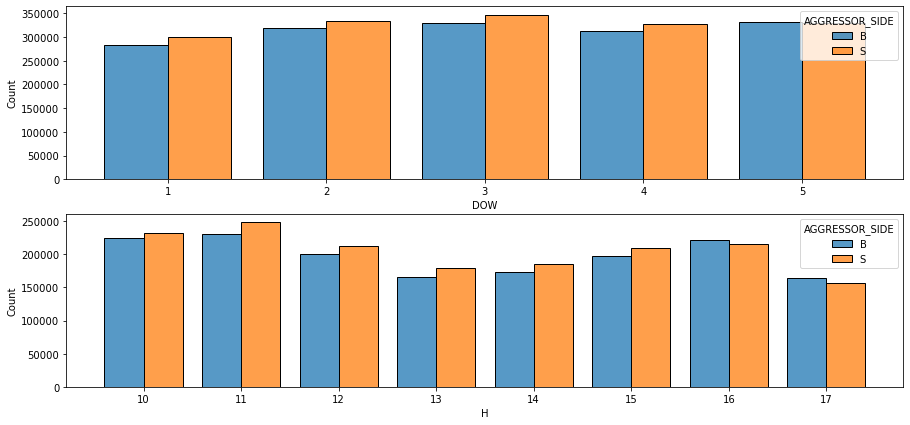

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))

sns.histplot(data=df, x='DOW', hue='AGGRESSOR_SIDE', multiple='dodge', discrete=True, shrink=0.8, ax=axes[0])
sns.histplot(data=df, x='H', hue='AGGRESSOR_SIDE', multiple='dodge', discrete=True, shrink=0.8, ax=axes[1])

So, frequency is changing over time and the share of buy orders is not constant over time too.

C:\Users\Sharp.Ra\AppData\Local\Temp/ipykernel_10788/679709689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H['xDateHour'] = df_H['Time'].map(lambda d: d.replace(minute=0, second=0, microsecond=0))


<AxesSubplot:xlabel='xDateHour', ylabel='Count'>

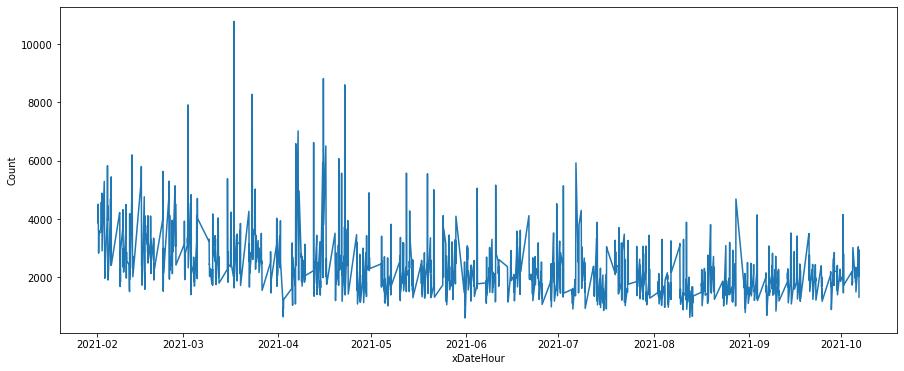

In [61]:
# Estimation of count of market orders per hour:
df_H = df[['Time', 'SIZE_sum', 'AGGRESSOR_SIDE', 'H']]
df_H['xDateHour'] = df_H['Time'].map(lambda d: d.replace(minute=0, second=0, microsecond=0))

order_frequency_H = df_H[['H', 'xDateHour', 'SIZE_sum']].groupby(by=['H', 'xDateHour'], as_index=False).count()
order_frequency_H_BS = df_H[['H', 'xDateHour', 'AGGRESSOR_SIDE', 'SIZE_sum']] \
    .groupby(by=['H', 'AGGRESSOR_SIDE', 'xDateHour'], as_index=False).count()

order_frequency_H.rename(columns={'SIZE_sum': 'Count'}, inplace=True)
order_frequency_H_BS.rename(columns={'SIZE_sum': 'Count'}, inplace=True)

order_frequency_H.sort_values(by=['xDateHour'], inplace=True)
plt.figure(figsize=(15, 6))
sns.lineplot(data=order_frequency_H, x='xDateHour', y='Count')

Text(0.5, 1.0, 'Share of buy orders')

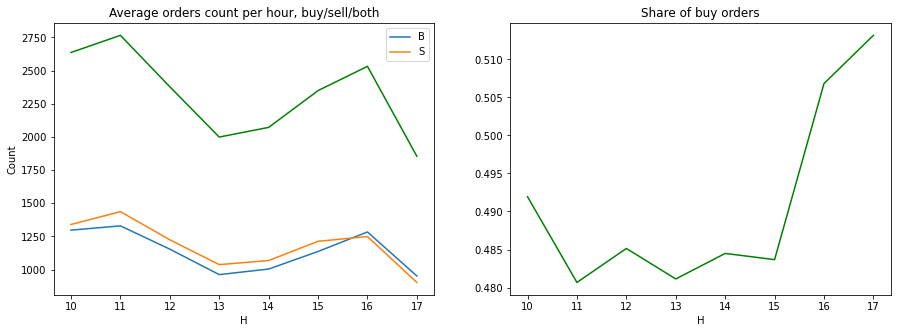

In [59]:
# Average number of market orders per hour and buy/sell ratio
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

order_frequency_H_BS_mean = order_frequency_H_BS[['H', 'AGGRESSOR_SIDE', 'Count']]\
        .groupby(by=['H', 'AGGRESSOR_SIDE'], as_index=False).mean()
order_frequency_H_mean = order_frequency_H[['H', 'Count']].groupby(by=['H'], as_index=False).mean()

sns.lineplot(data=order_frequency_H_BS_mean, x='H', y='Count', hue='AGGRESSOR_SIDE', ax=ax[0])
sns.lineplot(data=order_frequency_H_mean, x='H', y='Count', color='g', ax=ax[0])
ax[0].set_title("Average orders count per hour, buy/sell/both")

Y = order_frequency_H_BS_mean[order_frequency_H_BS_mean['AGGRESSOR_SIDE']=='B']['Count'].to_numpy()\
    / (order_frequency_H_BS_mean[order_frequency_H_BS_mean['AGGRESSOR_SIDE']=='S']['Count'].to_numpy() +
       order_frequency_H_BS_mean[order_frequency_H_BS_mean['AGGRESSOR_SIDE']=='B']['Count'].to_numpy())
sns.lineplot(data=order_frequency_H[['H', 'Count']].groupby(by=['H'], as_index=False).mean(),
            x='H', y=Y, color='g', ax=ax[1])
ax[1].set_title("Share of buy orders")

Obviously, the frequency is not constant and it depends on time and side. Also, share of buy orders is not constant over time but it close enough to 50%.

In [60]:
# Average count of market orders per hour total
order_frequency_H.Count.mean()

2323.502167630058

I used this value (__2300 orders an hour__) of order frequency in simulation, I don't distinguish frequency of buy and sell orders and put buy/sell ratio to 1 (50/50) during simulations.

#### 2. Spreads distribution

I also use same filtering and exclude first 10 minutes of trade session:

In [62]:
# Filter orders by time and day of week
df = market_orders[(market_orders['DOW']<=5) & 
                   (market_orders['H']>=10) & 
                   (market_orders['H']<=17) &
                   (market_orders['TimeOnly'] > datetime.time(10, 10, 0)) &
                   (market_orders['TimeOnly'] < datetime.time(17, 40, 0)) &
                   (market_orders['Spread'] != 0)]

df['Spread'] = np.round(df['Spread'] / 0.0025, decimals=0)  # convert spread ti ticks

C:\Users\Sharp.Ra\AppData\Local\Temp/ipykernel_10788/3656540849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spread'] = np.round(df['Spread'] / 0.0025, decimals=0)  # convert spread ti ticks


Text(0.5, 1.0, 'Spread (ticks) PMF, 1-7 ticks')

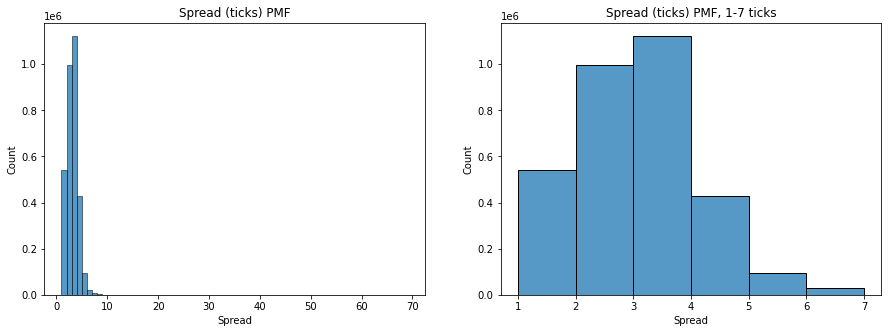

In [63]:
# Spread probability distribution
# X-axis in ticks
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x='Spread', binwidth=1, ax=ax[0])
ax[0].set_title('Spread (ticks) PMF')
sns.histplot(data=df[df['Spread']<=7.], x='Spread', binwidth=1, ax=ax[1])
ax[1].set_title('Spread (ticks) PMF, 1-7 ticks')

More than 99% spreads are less than 7 ticks:

In [64]:
# PMF for spreads (1-6 ticks)
spread_pmf = np.array([df[df['Spread'] == k]['Spread'].count() for k in range(1, 7)]) \
    / df[df['Spread'] <= 6]['Spread'].count()

for i, s in enumerate(spread_pmf):
    print(f"{i+1} ticks - {s*100:0.1f}%")

1 ticks - 16.9%
2 ticks - 31.1%
3 ticks - 35.0%
4 ticks - 13.4%
5 ticks - 2.9%
6 ticks - 0.7%


For generator of order book (see [Appendix E](#Appendix-e)) I use above statistics as PMF of spreads distribution. 

[To the top](#Content)
***

<a id="Summary-1"></a>
### Summary

We can make following conclusions:
1. __Power law__ fits empirical distribution __of order size__ sufficiently well. Tail index is about 2.0.
2. __Price impact__ for large orders is __proportianal to logarithm of size__ on average. The regression slope $K$ is equal to 0.0067.
3. Hour basis standard deviation of prices is about 0.17
4. Average __frequency of market orders__ is about __2300 per hour__. 
5. Share of buy orders roughly is close to 50%.




[To the top](#Content)
***

<a id="Simulations"></a>
## Chapter III. Simulations

In this chapter we provide results of strategy tests and comparison it with the benchmark strategy.

<a id="Base"></a>
### Simple base model

First of all I tested model in the same conditions as in original paper with the same simulation algorithm.
Algorithm is rather simple:

0. Start with $t=0$, 
1. For the next time moment $t_{i+1}=t_i+dt$ with intensity $\Lambda dt$ (Poisson stochastic process) generate market order event. With probability 50% it is buy order
2. Compute optimal market order prices $p_b, p_a$, distances $\delta_b, \delta_a$ and reservation price $r{\text -}price$
3. With probability $\lambda(\delta)=Ae^{-k\delta}$ market order fills limit order
4. If order executed then update cash and inventory
5. Generate next mid price in acordance with Brownian motion process. 

Algorithm for equidistant strategy is mostly the same with only difference in step 2.:

2. Compute optimal market order prices $p_b, p_a$, using average spread from AS-model (for comparable results)


Algorithm is implemented in separate file ```simulation.py``` and available on [GitHub](https://github.com/rasharp/FinalMDS) and [Appendix C](#Appendix-c).

Also base model simulations are available in ```Simple simulation.ipynb``` on [GitHub](https://github.com/rasharp/FinalMDS).

In [65]:
# module with simple strategy simulator
import simulation as sim

In [66]:
gamma = 0.1  # risk-aversion of MM
# parameters of market simulation
L = 210
alpha = 1.5
k = 1.5
A = L / alpha

# Time parameters
T = 1  # time horizon
dt = 0.005  # time quant

# Brownian motion parameters
mu = 0.0
sigma = 2.0

In [67]:
%%time
df_deals = sim.init_df_deals(start_price=100)  # init
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma)  # run simulation
df_deals = sim.add_df_deals(df_deals, np_deals)  # convert results to dataframe for convinience
df_deals[:5]

Wall time: 3.18 s


,Time,Wealth,Inventory,Deal side,Mid,Bid,Ask,R-price,Spread,PnL
1,0.005,0.0,0,0,100.336356,99.491971,101.180741,100.336356,1.68877,0.0
2,0.010,0.0,0,0,100.493601,99.650216,101.336987,100.493601,1.68677,0.0
3,0.015,0.0,0,0,100.462981,99.620596,101.305367,100.462981,1.68477,0.0
4,0.020,0.0,0,0,100.465749,99.624364,101.307134,100.465749,1.68277,0.0
5,0.025,0.0,0,0,100.578571,99.738186,101.418956,100.578571,1.68077,0.0


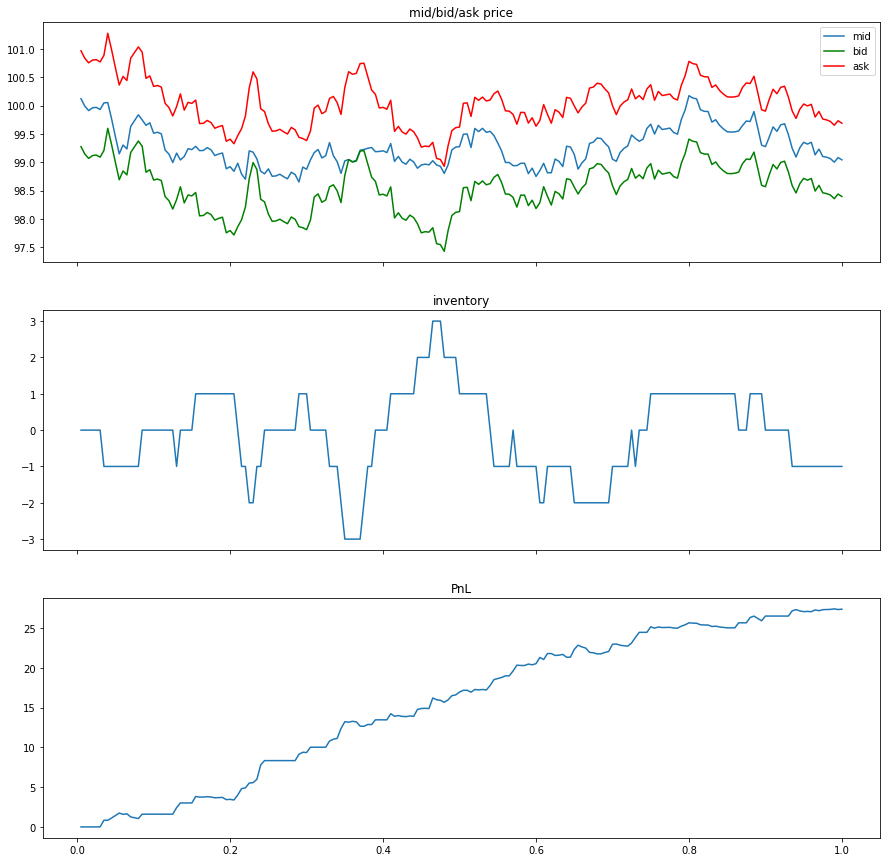

In [60]:
# Plots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
# axes[0].plot(df_deals['Time'], df_deals['R-price'], 'b--', label='r-price')
axes[0].plot(df_deals['Time'], df_deals['Bid'], 'g', label='bid')
axes[0].plot(df_deals['Time'], df_deals['Ask'], 'r', label='ask')
axes[0].title.set_text('mid/bid/ask price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

It is easy to notice that there shift in prices when inventory is not zero. The more inventory dealer has the greater shift.
Now let's check benchmark strategy with same parameters.

In [62]:
# Example of equidistant strategy execution with same average spread
avg_spread = df_deals['Spread'].mean()
df_deals = sim.init_df_deals(start_price=100)
np_deals = sim.simulation_symm_run(df_deals.to_numpy(), avg_spread, avg_spread, A, k, T, dt, mu, sigma)
df_deals = sim.add_df_deals(df_deals, np_deals)

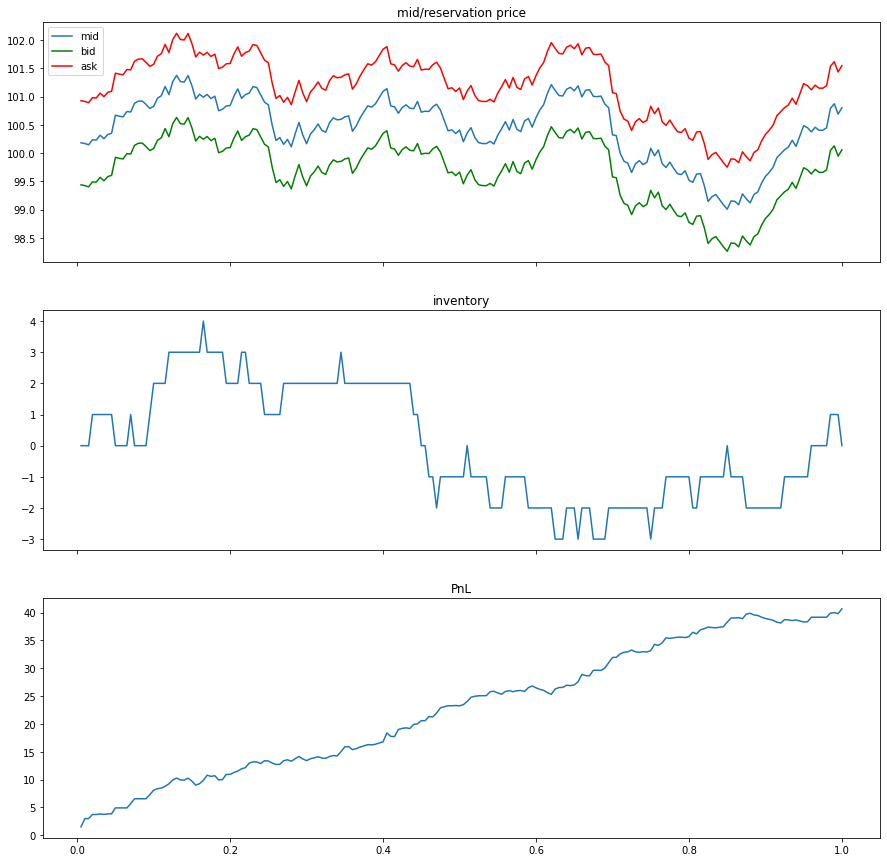

In [63]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['Bid'], 'g', label='bid')
axes[0].plot(df_deals['Time'], df_deals['Ask'], 'r', label='ask')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

In contrast to previous model benchmark doesn't shift prices.

Now let's check and compare distribution of profits and inventory.

In [68]:
%%time
# Run 1000 simulations to extimate distribution
df_simres_bm = sim.run_sims(1000, start_price=100, gamma=0.1, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma)

Wall time: 3.11 s


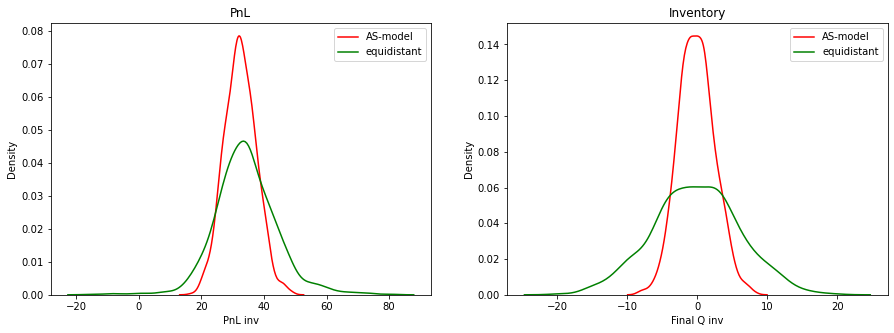

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_bm, x='PnL inv', color='r', ax=axes[0], label='AS-model')
sns.kdeplot(data=df_simres_bm, x='PnL const', color='g', ax=axes[0], label='equidistant')
axes[0].set_title("PnL")
axes[0].legend()

sns.kdeplot(data=df_simres_bm, x='Final Q inv', color='r', ax=axes[1], label='AS-model')
sns.kdeplot(data=df_simres_bm, x='Final Q const', color='g', ax=axes[1], label='equidistant')
axes[1].set_title("Inventory")
axes[1].legend()

In [70]:
# same with gamma = 1.
df_simres_bm = sim.run_sims(1000, start_price=100, gamma=1, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


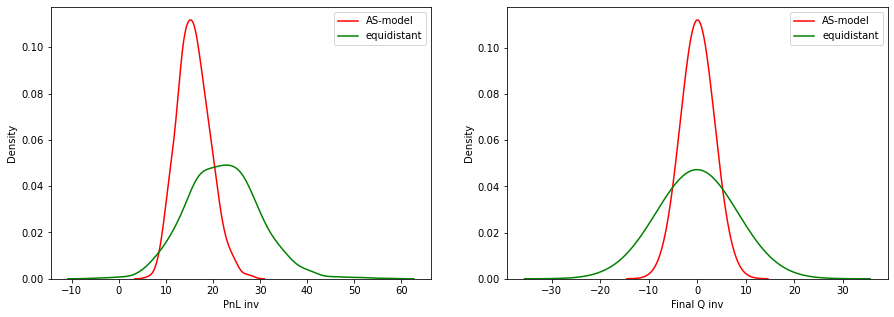

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_bm, x='PnL inv', color='r', ax=axes[0], label='AS-model')
sns.kdeplot(data=df_simres_bm, x='PnL const', color='g', ax=axes[0], label='equidistant')
axes[0].legend()

sns.kdeplot(data=df_simres_bm, x='Final Q inv', color='r', ax=axes[1], bw=2, label='AS-model')
sns.kdeplot(data=df_simres_bm, x='Final Q const', color='g', ax=axes[1], bw=2, label='equidistant')
axes[1].legend()

Results are quite similar to the ones in the original paper. Now let's test with real market parameters.

[To the top](#Content)
***

<a id="Base-USDRUB"></a>
### Simple base model for USDRUB

In this simulation we use estimatied parameters and take into account the tick size for USDRUB market (just rounding all prices). Algorithm is the same as in the  previous one. Tick size is equal to 0.0025 ruble.

In [65]:
gamma = 0.1
alpha = 2.0
K = 0.0067 
ticksize = 0.0025

# parameters of market simulation
T = 1  # one hour
dt = 0.5 / 3600  # 0.5 second
L = 2300 # number of market orders per hour (Poisson lambda)

k = alpha / K 
A = L / alpha

# Brownian motion parameters (rough estimation)
mu = 0.  # no drift
sigma = 0.17

In [66]:
%%time
start_price = 70.

# Example run
df_deals = sim.init_df_deals(start_price)
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize)
df_deals = sim.add_df_deals(df_deals, np_deals)

Wall time: 157 ms


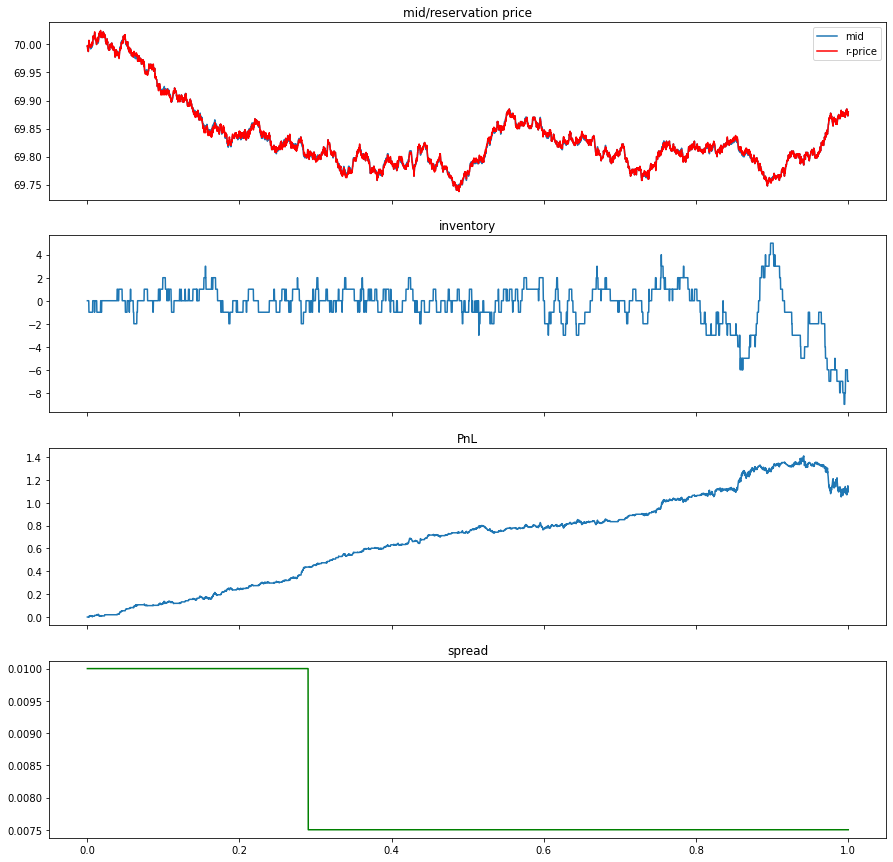

In [67]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

Run 1000 simulations to obtain and compare profit-loss and inventory distributions. Remind that equidistant strategy uses spread equals to mean AS-model spread to provide models comparability. Firstly for $\gamma = 0.1$: 

In [69]:
# Run 1000 simulations to extimate distribution, gamma = 0.1
df_simres = sim.run_sims(1000, start_price=start_price, 
                         gamma=gamma, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma, ticksize=ticksize)

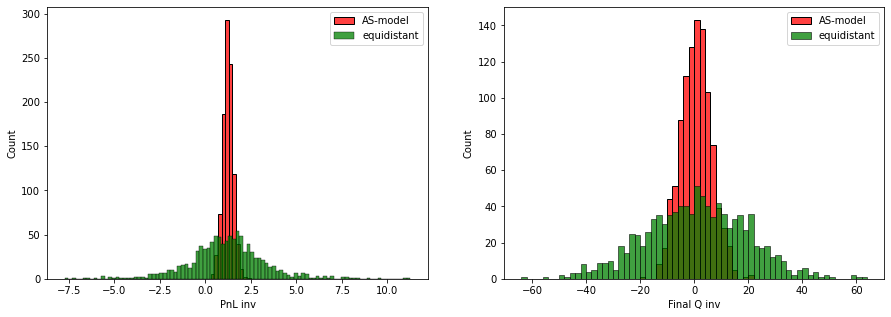

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='AS-model', binwidth=0.2)
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='equidistant', binwidth=0.2)
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='AS-model', binwidth=2)
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='equidistant', binwidth=2)
axes[1].legend()

In [74]:
df_res = pd.DataFrame(columns=['Mean PL', 'Std PL', 'Mean inventory', 'Std inventory'], 
                      index=['AS-model', 'Equidistant'])
df_res.loc['AS-model', 'Mean PL'] = df_simres['PnL inv'].mean()
df_res.loc['AS-model', 'Std PL'] = df_simres['PnL inv'].std()
df_res.loc['AS-model', 'Mean inventory'] = df_simres['Final Q inv'].mean()
df_res.loc['AS-model', 'Std inventory'] = df_simres['Final Q inv'].std()

df_res.loc['Equidistant', 'Mean PL'] = df_simres['PnL const'].mean()
df_res.loc['Equidistant', 'Std PL'] = df_simres['PnL const'].std()
df_res.loc['Equidistant', 'Mean inventory'] = df_simres['Final Q const'].mean()
df_res.loc['Equidistant', 'Std inventory'] = df_simres['Final Q const'].std()

df_res

,Mean PL,Std PL,Mean inventory,Std inventory
AS-model,1.239735,0.28061,0.151,5.654394
Equidistant,1.176139,2.144163,0.276,18.913211


Great advantange of AS-model strategy is comparable mean profit with much less volatility especially in final inventory. It means AS-model has sighnificantly less risks than benchmark. Let's try with $\gamma = 1$:

In [75]:
# Run 1000 simulations to extimate distribution with greater risk aversion: gamma = 1
gamma = 1.
df_simres = sim.run_sims(1000, start_price=start_price, 
                         gamma=gamma, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma, ticksize=ticksize)

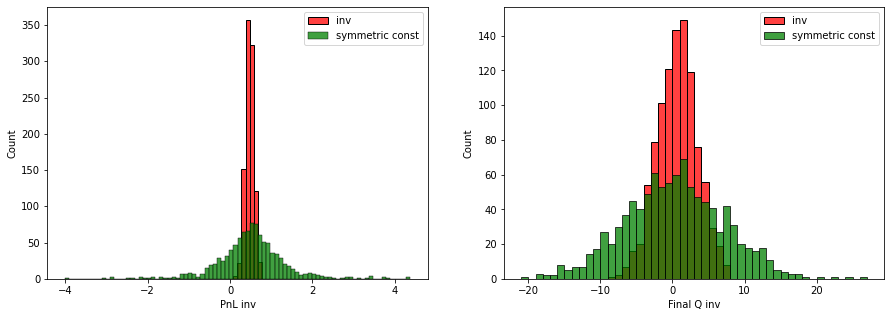

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv', binwidth=0.1)
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const', binwidth=0.1)
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv', binwidth=1)
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const', binwidth=1)
axes[1].legend()

In [77]:
df_res = pd.DataFrame(columns=['Mean PL', 'Std PL', 'Mean inventory', 'Std inventory'], 
                      index=['AS-model', 'Equidistant'])
df_res.loc['AS-model', 'Mean PL'] = df_simres['PnL inv'].mean()
df_res.loc['AS-model', 'Std PL'] = df_simres['PnL inv'].std()
df_res.loc['AS-model', 'Mean inventory'] = df_simres['Final Q inv'].mean()
df_res.loc['AS-model', 'Std inventory'] = df_simres['Final Q inv'].std()

df_res.loc['Equidistant', 'Mean PL'] = df_simres['PnL const'].mean()
df_res.loc['Equidistant', 'Std PL'] = df_simres['PnL const'].std()
df_res.loc['Equidistant', 'Mean inventory'] = df_simres['Final Q const'].mean()
df_res.loc['Equidistant', 'Std inventory'] = df_simres['Final Q const'].std()

df_res

,Mean PL,Std PL,Mean inventory,Std inventory
AS-model,0.46718,0.100324,0.111,2.788271
Equidistant,0.511237,0.830291,-0.218,6.935891


And results are highly similar: mean profits are close each other, final inventory mean is almost zero, standard deviations for AS-model are sighnificantly less.

In both cases AS-strategy provides more concentrated PnL and inventory and much less volatility both of profits and final inventory.

[To the top](#Content)
***

<a id="Historical"></a>
### Historical simulation

Base algorithm is simple and mostly based on our assumptions about market microstructure. Much more interesting test strategies on real data. Here we provide results of historical simulations. 

For this kind of simulations I use another engine implemented in ```strategies.py``` and available on [GitHub](https://github.com/rasharp/FinalMDS), see also [Appendix D](#Appendix-d). It can run strategies on any order book data as generated as historical.

Historical and advanced simulations are available on [GitHub](https://github.com/rasharp/FinalMDS) in ```Simulation.ipynb```

In [79]:
import strategies

In [80]:
# Example of run for 02.07.2021 11.00-12.00
start_date = datetime.datetime(2021, 7, 2, 11, 0, 0)
end_date = datetime.datetime(2021, 7, 2, 12, 0, 0)
# Filter market order data
df = market_orders[(market_orders['Time'] >= start_date) &
                   (market_orders['Time'] <= end_date)]

In [81]:
sta = strategies.ASModel1Strategy(ticksize=ticksize, gamma=0.1, k=k, sigma=sigma)  # same parameters as above

In [82]:
df_deals = sta.run_period_sim(df, W=0, Q=0, min_spread=2, max_distance=5)  # run using dataframe with orders as input

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:455: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sample run of AS-model on order book for 02.07.2021 11.00-12.00

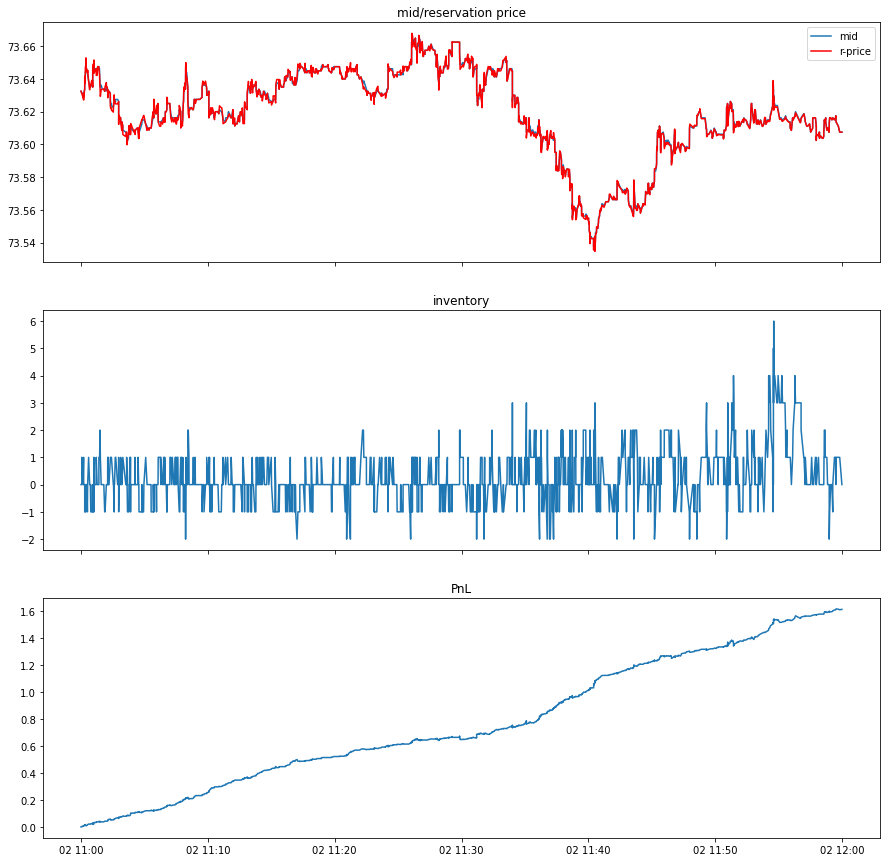

In [83]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

Run of equidistant strategy on same data:

In [87]:
# same dates, equidistant strategy
ste = strategies.EquiDistantStrategy(ticksize=0.0025)

In [88]:
df_deals = ste.run_period_sim(df, distance=2)  # 2 ticks distance from mid

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:260: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



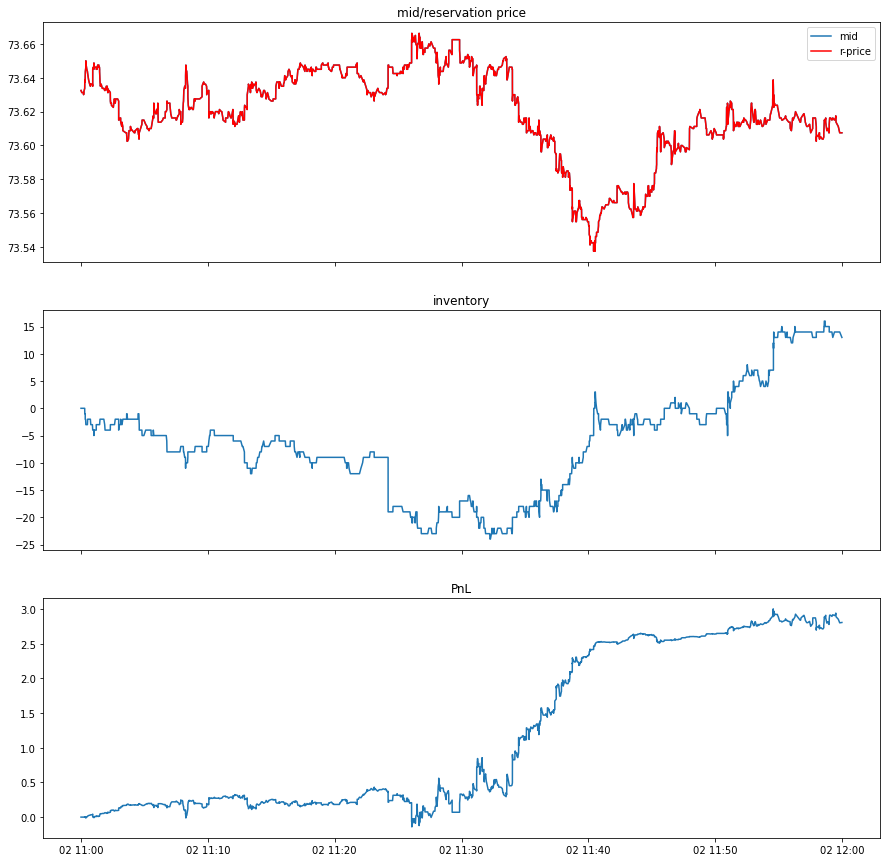

In [89]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')


Now run simulation based on 500 randomly choosen trade hours from history to assess distributions.

In [90]:
def sampler_realdata(market_orders, n, time_horizon):
    """
    Generator of input dataframes for simulation.
    """
    session_start = 10
    session_end = 17
    df = market_orders[(market_orders['H']>=session_start) & (market_orders['H']<=session_end)]
    dates = np.random.choice(df['Date'].unique(), n)  # choice random dates
    hours = np.random.choice(range(session_start, session_end-time_horizon), n)  # choice random hours
    
    for date, hour in zip(dates, hours):
        yield df[(df['H']==hour) & (df['Date']==date)]

In [97]:
columns = ['A_PL', 'A_MinPL', 'A_Q', 'A_MaxQ', 'A_N', 'A_avPL', 
           'B_PL', 'B_MinPL', 'B_Q', 'B_MaxQ', 'B_N', 'B_avPL']  # columns of result dataframe

def add_sim(df_simres, df_deals_A, df_deals_B):
    """
    Auxilary function
    """
    # Statistics: PL, MinPL, Q, MaxQ,
    last_deal_A = df_deals_A.iloc[-1]
    last_deal_B = df_deals_B.iloc[-1]
    
    row = {}
    row['A_PL'] = last_deal_A['PnL']
    row['A_MinPL'] = df_deals_A['PnL'].min()
    row['A_Q'] = last_deal_A['Inventory']
    row['A_MaxQ'] = df_deals_A['Inventory'].abs().max()
    row['A_N'] = df_deals_A[df_deals_A['Side']!=0].shape[0]
    row['A_avPL'] = last_deal_A['PnL'] / df_deals_A[df_deals_A['Side']!=0].shape[0]
    
    row['B_PL'] = last_deal_B['PnL']
    row['B_MinPL'] = df_deals_B['PnL'].min()
    row['B_Q'] = last_deal_B['Inventory']
    row['B_MaxQ'] = df_deals_B['Inventory'].abs().max()
    row['B_N'] = df_deals_B[df_deals_B['Side']!=0].shape[0]
    row['B_avPL'] = last_deal_B['PnL'] / df_deals_B[df_deals_B['Side']!=0].shape[0]

    return df_simres.append(pd.DataFrame(row, index=[0]), ignore_index=True)

In [98]:
# RUN SIMULATION
df_simres = pd.DataFrame(columns=columns)
N = 500  # number of runs

for df in tqdm(sampler_realdata(market_orders, N, 1), total=N):
    if df.shape[0] == 0:
        continue

    df_deals_EQ = ste.run_period_sim(df, distance=2)
    df_deals_AS = sta.run_period_sim(df, W=0, Q=0, min_spread=2, max_distance=5)
    df_simres = add_sim(df_simres, df_deals_AS, df_deals_EQ)

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:260: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sharp.Ra\PyProjects\FinalMDS\strategies.py:455: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

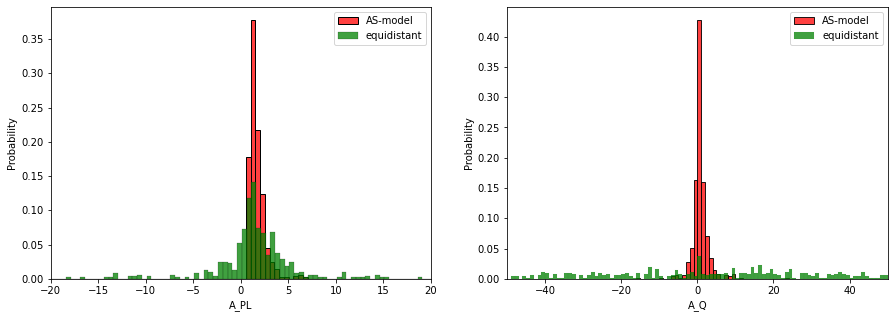

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='A_PL', color='r', ax=axes[0], label='AS-model', binwidth=0.5, stat='probability')
sns.histplot(data=df_simres, x='B_PL', color='g', ax=axes[0], label='equidistant', binwidth=0.5, stat='probability')
axes[0].set_xlim([-20, 20])
axes[0].legend()

sns.histplot(data=df_simres, x='A_Q', color='r', ax=axes[1], label='AS-model', binwidth=1, stat='probability')
sns.histplot(data=df_simres, x='B_Q', color='g', ax=axes[1], label='equidistant', binwidth=1, stat='probability')
axes[1].set_xlim([-50, 50])
axes[1].legend()

In [100]:
df_res = pd.DataFrame(columns=['Mean PL', 'Std PL', 'Mean inventory', 'Std inventory'], 
                      index=['AS-model', 'Equidistant'])
df_res.loc['AS-model', 'Mean PL'] = df_simres['A_PL'].mean()
df_res.loc['AS-model', 'Std PL'] = df_simres['A_PL'].std()
df_res.loc['AS-model', 'Mean inventory'] = df_simres['A_Q'].mean()
df_res.loc['AS-model', 'Std inventory'] = df_simres['A_Q'].std()

df_res.loc['Equidistant', 'Mean PL'] = df_simres['B_PL'].mean()
df_res.loc['Equidistant', 'Std PL'] = df_simres['B_PL'].std()
df_res.loc['Equidistant', 'Mean inventory'] = df_simres['B_Q'].mean()
df_res.loc['Equidistant', 'Std inventory'] = df_simres['B_Q'].std()

df_res

,Mean PL,Std PL,Mean inventory,Std inventory
AS-model,1.641442,0.845523,0.217742,2.37771
Equidistant,1.481362,6.780514,6.860887,84.429486


Difference is really impressive: profits are comparable but volatility of profits is 8 times less for AS-model. Invetory volatility difference is huge: AS-model final inventory volatility is almost 30 times less. So, AS-model produces much more concentrated results. 

Another important conclusion is that base simple simulation algorithm is far from reality because of sighnificant differences in distribution of final inventory for equidistant strategy.

Consider also number of deals, profit per deal and maximum inventory:

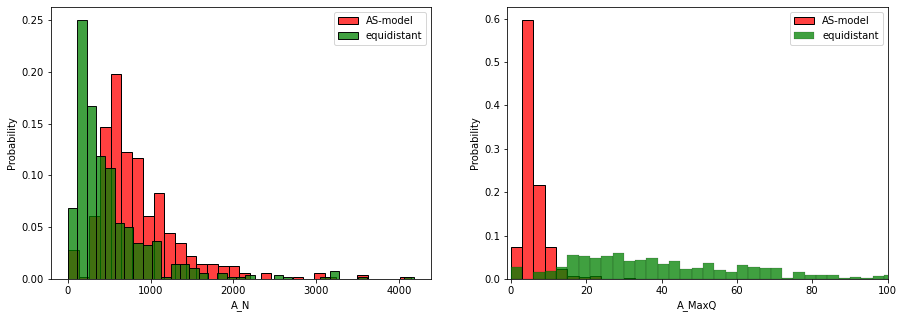

In [101]:
# Some additional statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='A_N', color='r', ax=axes[0], label='AS-model', stat='probability')
sns.histplot(data=df_simres, x='B_N', color='g', ax=axes[0], label='equidistant', stat='probability')
axes[0].legend()

sns.histplot(data=df_simres, x='A_MaxQ', color='r', ax=axes[1], label='AS-model', binwidth=3, stat='probability')
sns.histplot(data=df_simres, x='B_MaxQ', color='g', ax=axes[1], label='equidistant', binwidth=3, stat='probability')
axes[1].set_xlim([-1, 100])
axes[1].legend()

In [106]:
df_res = pd.DataFrame(columns=['Mean N', 'Std N', 'Mean max inventory', 'Std max inventory'], 
                      index=['AS-model', 'Equidistant'])

df_res.loc['AS-model', 'Mean N'] = df_simres['A_N'].mean()
df_res.loc['AS-model', 'Std N'] = df_simres['A_N'].std()
df_res.loc['AS-model', 'Mean max inventory'] = df_simres['A_MaxQ'].mean()
df_res.loc['AS-model', 'Std max inventory'] = df_simres['A_MaxQ'].std()

df_res.loc['Equidistant', 'Mean N'] = df_simres['B_N'].mean()
df_res.loc['Equidistant', 'Std N'] = df_simres['B_N'].std()
df_res.loc['Equidistant', 'Mean max inventory'] = df_simres['B_MaxQ'].mean()
df_res.loc['Equidistant', 'Std max inventory'] = df_simres['B_MaxQ'].std()

df_res

,Mean N,Std N,Mean max inventory,Std max inventory
AS-model,846.612903,529.992917,5.278226,3.245387
Equidistant,521.002016,540.090836,58.951613,73.057012


Two key issues here are:
- AS-model strategy tends to trade more often
- equidistant strategy has significant risk of having huge directed position

[To the top](#Content)
***

<a id="Generator"></a>
### Advanced simulation

As it is shown in historical simulation simple simulation is far from reality. So, we try to impove simulation procedure to obtain comparable results.
First idea is use two-component volume-impact distribution: one for regular orders and another for x50 orders. Second idea is generate both best bid and best ask prices as combination of Brownian motion and spread random variable.

Algorithm is following:
1. Using Poisson process with constant intensity $\Lambda$ obtain series of time of market order events.
1. With probability 50% (close to historical share) new order is buy order.
1. With probability $P_{x50}$ new order is x50-order, otherwise it is regular. Probability is estimated based on historical data (share of x50 orders) and is equal to __36%__.

2. Using Brownian motion process I obtain bid prices and round them to ticks.
3. Using spread distribution (PMF) I generate spread for each bid and obtain ask prices.

4. Using empirical PMF for x50 order volumes/impacts I generate x50 order parameter (volume, impact) OR
using Kernel density estimation model for regular order volumes/impacts I generate regular order parameters.

Implementation is in file ```generator.py``` on [GitHub](https://github.com/rasharp/FinalMDS) and [Appendix-E](#Appendix-e).

Below test results of advanced generator are provided.

In [107]:
import generator

In [108]:
gen = generator.Market(mu=0., sigma=0.17, ticksize=0.0025, spread_pmf=spread_pmf)

In [109]:
# Load KDE model for regular volumes
gen.init_xx_model('kde_model.pickle')

In [110]:
# LOAD distribution PMF for x50 volumes/impact
gen.init_x0_model('PMFx50.npz')

In [111]:
# Order book generation example
dfg = gen.order_book(2200, 75., start_date, end_date, 0.5, 0.36)
dfg[:5]

,Time,Side,Volume,Impact,BID,ASK
0,2021-07-02 11:00:01.362375,-1,500.0,0.0000,75.0025,75.0075
1,2021-07-02 11:00:02.741252,-1,50.0,0.0000,75.0025,75.0075
2,2021-07-02 11:00:04.250660,-1,11.0,0.0000,75.0025,75.0075
3,2021-07-02 11:00:06.075569,1,50.0,0.0000,75.0075,75.0175
4,2021-07-02 11:00:06.221983,1,200.0,0.0025,75.0050,75.0100


In [112]:
df_simres = pd.DataFrame(columns=columns)

for _ in tqdm(range(500)):
    dfg = gen.order_book(2200, 75., start_date, end_date, 0.5, 0.36)  # generate order book

    df_deals_EQ = ste.run_period_sim(dfg, distance=2, preprocess=False)
    df_deals_AS = sta.run_period_sim(dfg, W=0, Q=0, min_spread=2, max_distance=5, preprocess=False)
    df_simres = add_sim(df_simres, df_deals_AS, df_deals_EQ)

  0%|          | 0/500 [00:00<?, ?it/s]

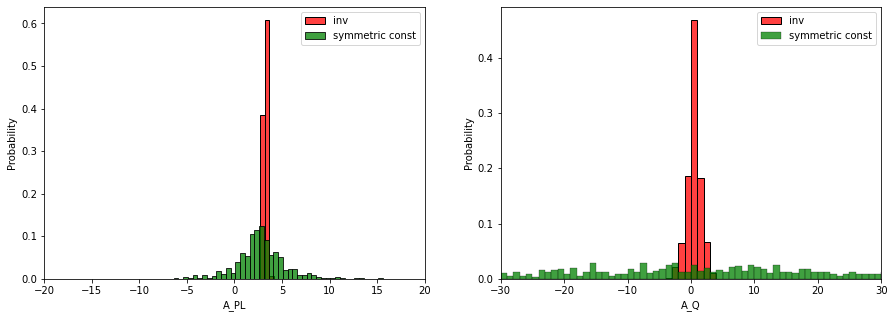

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='A_PL', color='r', ax=axes[0], label='inv', binwidth=0.5, stat='probability')
sns.histplot(data=df_simres, x='B_PL', color='g', ax=axes[0], label='symmetric const', binwidth=0.5, stat='probability')
axes[0].set_xlim([-20, 20])
axes[0].legend()

sns.histplot(data=df_simres, x='A_Q', color='r', ax=axes[1], label='inv', binwidth=1, stat='probability')
sns.histplot(data=df_simres, x='B_Q', color='g', ax=axes[1], label='symmetric const', binwidth=1, stat='probability')
axes[1].set_xlim([-30, 30])
axes[1].legend()

In [113]:
df_res = pd.DataFrame(columns=['Mean PL', 'Std PL', 'Mean inventory', 'Std inventory'], 
                      index=['AS-model', 'Equidistant'])
df_res.loc['AS-model', 'Mean PL'] = df_simres['A_PL'].mean()
df_res.loc['AS-model', 'Std PL'] = df_simres['A_PL'].std()
df_res.loc['AS-model', 'Mean inventory'] = df_simres['A_Q'].mean()
df_res.loc['AS-model', 'Std inventory'] = df_simres['A_Q'].std()

df_res.loc['Equidistant', 'Mean PL'] = df_simres['B_PL'].mean()
df_res.loc['Equidistant', 'Std PL'] = df_simres['B_PL'].std()
df_res.loc['Equidistant', 'Mean inventory'] = df_simres['B_Q'].mean()
df_res.loc['Equidistant', 'Std inventory'] = df_simres['B_Q'].std()

df_res

,Mean PL,Std PL,Mean inventory,Std inventory
AS-model,3.21934,0.177327,-0.106,1.137256
Equidistant,2.650802,2.639014,0.114,22.849183


Generator is not perfect, but provides results more similar to historical than simple one. Again mean values are comparable but volatility for benchmark strategy is much higher.

In [114]:
df_res = pd.DataFrame(columns=['Mean N', 'Std N', 'Mean max inventory', 'Std max inventory'], 
                      index=['AS-model', 'Equidistant'])

df_res.loc['AS-model', 'Mean N'] = df_simres['A_N'].mean()
df_res.loc['AS-model', 'Std N'] = df_simres['A_N'].std()
df_res.loc['AS-model', 'Mean max inventory'] = df_simres['A_MaxQ'].mean()
df_res.loc['AS-model', 'Std max inventory'] = df_simres['A_MaxQ'].std()

df_res.loc['Equidistant', 'Mean N'] = df_simres['B_N'].mean()
df_res.loc['Equidistant', 'Std N'] = df_simres['B_N'].std()
df_res.loc['Equidistant', 'Mean max inventory'] = df_simres['B_MaxQ'].mean()
df_res.loc['Equidistant', 'Std max inventory'] = df_simres['B_MaxQ'].std()

df_res

,Mean N,Std N,Mean max inventory,Std max inventory
AS-model,1030.982,32.17465,3.682,0.788746
Equidistant,492.93,21.483953,27.386,11.949837


Results are less impressive than historical but comparable. Again AS-model trades more often and more concentrated.

[To the top](#Content)
***

<a id="Conclusions"></a>
## Conclusions and further plans

We have researched microstructure propeties of Russian currency market by the USB/RUB example (most traded pair). We finds that distribution of volumes of large market orders follows power law with tail index equals to $2$. Also we find that distribution highly likely consists of several components, and estimation of these components separately provide similar results.

We investigate relationship between average instant (virtual) price impact and market order size: it is linear for small-size orders and logarithmic for large-size ones. Analysis shown that mentioned above components have the same relationships. It is crucial for us because we interested first in large and often happen orders (like 500 lots).

Finally we have made simulations to test and compare results of benchmark equidistant strategy and strategy based on quasi-optimal Avellaneda-Stoikov model. We can conlude that advanced model has comparable mean profit and mean final inventory, but also sighnificantly less volatility of these metrics. Also it means that AS-model strategy is much less risky because of less chance of adverse inventory revaluation. The great advandantage of this model is its simplisity.


We have to mention some drawbacks of our simulation process:
1. Transaction costs are not included, but it is rather simple to include. It can affect model results dramatically if there size is higher than average profit a deal. It is fair to say that it is not issue of the AS-model only, it is an issue for any HFT market-making strategy.
2. Partial execution of market orders. Touching the price by market order does not guarantee limit order execution. It is the substantial drawback in current simulation.

Further steps:
1. Test on real market is logical next step to approve model applicability in real conditions.
2. Improving model. It is possible to avoid some assumptions by solving PDE numerically. But the problem here is how to estimate model arrival rates $\lambda(\delta)$.
3. Improve simulation with more complicated model of market microstructure. E.g. taking into account partial order execution which is the most weak point in simulation.
3. Improve simulation with fractional Brownian motion instead of simple one.
4. Taking into account transaction costs.


[To the top](#Content)
***

## References

1. Avellaneda, M., Stoikov S. High-frequency trading in a limit order book. Quantitative Finance, 2008
1. Ho, T. and Stoll, H., Optimal dealer pricing under transactions and return uncertainty. Journal of Financial Economics, 1981
1. Davis, M.A.A., Linear estimation and stochastic control, 1977
2. Gopikrishnan, P., Plerou, V., Gabaix, X. and Stanley, H.E. Statistical properties of share volume traded in financial markets. Physical review E., 2000
2. Gabaix, X., Gopikrishnan, P., Plerou, V. and Stanley, H.E., Institutional investors and stock market volatility. Quartely Journal of Economics, 2006
2. Maslow, S. and Mills, M., Price fluctuations from the order book perspective: empirical facts and a simple model. Physica A, 2001
3. Potters, M. and Bouchaud, J-P., More statistical properties of order books and price impact. Physica A, 2003
3. Weber, P. and Rosenow, B., Order book approach to price impact. Quantitative Finance, 2005
4. I.I. Komarov, H.L. Chen. Application of the Hill method for the tail index estimation. Informatica, 2010
4. Munasinghe, R., Kossinna P., Jayasinghe D., Wijeratne D. Tail Index Estimation for Power Law Distributions in R. Finance & Stochastic Processes, 2020

[To the top](#Content)
***

<a id="Appendix-a"></a>
## Appendix A. Preprocessing.

Input data has following structure (trade of the deals from MOEX):

In [4]:
data[:5]

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
0,2021-02-01 10:00:00.271880,75.5975,100,B,7559750.0
1,2021-02-01 10:00:00.271880,75.6000,500,B,37800000.0
2,2021-02-01 10:00:00.271880,75.6700,63,B,4767210.0
3,2021-02-01 10:00:00.304507,75.6625,10,B,756625.0
4,2021-02-01 10:00:00.346729,75.6575,3,B,226972.5


Output format is the followig:

In [10]:
market_orders[:5]

,Time,AGGRESSOR_SIDE,PRICE_min,PRICE_max,SIZE_sum,Date,TimeOnly,DOW,H,Impact,BID,ASK,MID,Spread
0,2021-02-01 10:00:00.271880,B,75.5975,75.6700,663,2021-02-01,10:00:00.271880,1,10,0.0725,75.565002,75.599998,75.582504,0.0350
1,2021-02-01 10:00:00.304507,B,75.6625,75.6625,10,2021-02-01,10:00:00.304507,1,10,0.0000,75.567497,75.662498,75.614998,0.0950
2,2021-02-01 10:00:00.346729,B,75.6575,75.6575,3,2021-02-01,10:00:00.346729,1,10,0.0000,75.602501,75.657501,75.630005,0.0550
3,2021-02-01 10:00:00.360369,S,75.6025,75.6025,20,2021-02-01,10:00:00.360369,1,10,0.0000,75.602501,75.625000,75.613754,0.0225
4,2021-02-01 10:00:00.377261,S,75.6025,75.6025,4,2021-02-01,10:00:00.377261,1,10,0.0000,75.602501,75.639999,75.621246,0.0375


```preprocess.py``` source code:

In [ ]:
"""
Module provides functions for market order book preprocessing
"""
import datetime
import pandas as pd
import numpy as np
import numba


# All preprocessing in one function
def preprocess_deals_data(data, vol_bins=None, vol_labels=None):
    """
    Preprocess dataframe with deals
    Consolidate market orders, returns new dataframe
    Add features: Day of week, Hour, Time
    """
    # aggregate to obtain market order instant impact
    # deals with the same time are caused by one market order
    data = data.groupby(by=['Time', 'AGGRESSOR_SIDE'], as_index=False) \
        .agg({'PRICE': ['min', 'max'], 'SIZE': 'sum', })

    # Flatten columns names(!)
    data.columns = ['_'.join(z) if z[1] != '' else z[0] for z in data.columns]

    # Add datetime features
    data['Date'] = data['Time'].map(lambda d: d.date())  # only date
    data['TimeOnly'] = data['Time'].map(lambda d: d.time())  # only time
    data['DOW'] = data['Time'].map(lambda d: d.isoweekday())  # day of week
    data['H'] = data['Time'].map(lambda d: d.hour)  # hour (for filtering)

    # Impact calculation
    data['Impact'] = data['PRICE_max'] - data['PRICE_min']

    return data


@numba.njit()
def process_day(order_time, time, bid, ask):
    """
    Function gets order time array, and market bid, ask and time array
    For each element in order time array it finds bid and ask
    Returns arrays of bids ands asks for orders
    """
    j = 0
    res_bid = np.zeros_like(order_time, dtype=np.float32)
    res_ask = np.zeros_like(order_time, dtype=np.float32)
    for i, t in enumerate(order_time):
        while time[j] < t:
            j += 1
        res_bid[i] = bid[j]
        res_ask[i] = ask[j]

    return res_bid, res_ask


def extract_day(dt, orders, LOB_folder, LOB_prefix):
    """
    Function gets date, opens corresponding file with LOB history
    and return best bid, best ask and time arrays
    Also return order history time array from deals file (all in numpy format for numba)
    """
    orders_time = orders[orders['Date'] == dt.date()]['Time'].to_numpy()

    fname = LOB_folder + LOB_prefix + dt.strftime('%m%d') + '.feather'
    lob_df = pd.read_feather(fname)
    time_lob = lob_df['Time'].to_numpy()
    bid_lob = lob_df['BID_PRICE1'].to_numpy()
    ask_lob = lob_df['ASK_PRICE1'].to_numpy()
    return orders_time, time_lob, bid_lob, ask_lob


def date_range(start_date, end_date, only_workdays=False):
    """
    Simple generator to obtain dates in defined date range
    """
    for i in range(int((end_date - start_date).days) + 1):
        dt = start_date + datetime.timedelta(days=i)
        if only_workdays and dt.isoweekday() in [6, 7]:
            continue
        yield start_date + datetime.timedelta(days=i)


def add_lob_prices(market_orders, start_date, end_date, LOB_folder, LOB_prefix):
    """
    Function processes market order dataframe and add bid and ask columns
    Returns new dataframe
    """
    for dt in date_range(start_date, end_date, only_workdays=True):
        fname = LOB_folder + LOB_prefix + dt.strftime('%m%d') + '.feather'
        try:
            lob_df = pd.read_feather(fname)
        except FileNotFoundError:
            print(f"{dt} skipped")
            continue

        if lob_df.shape[0] == 0:
            print(f"{fname} no quotes")
            continue

        order_time, lob_time, lob_bid, lob_ask = extract_day(dt, market_orders, LOB_folder, LOB_prefix)
        order_bid, order_ask = process_day(order_time, lob_time, lob_bid, lob_ask)

        market_orders.loc[market_orders['Date'] == dt.date(), 'BID'] = order_bid
        market_orders.loc[market_orders['Date'] == dt.date(), 'ASK'] = order_ask

    market_orders['MID'] = (market_orders['BID'] + market_orders['ASK']) / 2
    market_orders['Spread'] = market_orders['ASK'] - market_orders['BID']

    return market_orders


def main(data_file_name, LOB_folder, LOB_prefix, start_date, end_date, output_file_name):
    print('1. Read data')
    data = pd.read_feather(data_file_name)
    print('2. Preprocess data')
    market_orders = preprocess_deals_data(data)
    print('3. Add market quotes')
    market_orders = add_lob_prices(market_orders, start_date, end_date, LOB_folder, LOB_prefix)
    print('4. Save result')
    market_orders.to_feather(output_file_name)
    # print(market_orders[:5])


if __name__ == "__main__":
    main('Data/USDRUB_TOM_trades.feather',
         'Data\\LOB_USDRUB\\', 'LOB_',
         datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'),
         datetime.datetime.strptime('2021-10-06', '%Y-%m-%d'),
         'market_orders_USDRUB_.feather')
    print('Done!')


[To the top](#Content)
***

<a id="Appendix-b"></a>
## Appendix B. Tail exponent.

```tail_index.py``` source code:

In [ ]:
"""
Module provide several methods for tail index estimaition
"""
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def hill_estimator(x, k_range=None) -> np.ndarray:
    """
    Tail index estimation using Hill method
    Function calculate Hill estimations
        H(k, n) = 1/k SUM(log(X[n-i+1]) - log(X[n-k]) for i in [1,k])
        H -> 1/Tail index when n -> inf
        Hill's tail index estimation
        Tail index = 1 / AVG(H) for k in [k1, k2]
        where k1 and k2 chosen empirically (usually based on graph of H(k)
    Function returns np.array of 1/H(k)    
    """    
    x = np.sort(x)
    n = len(x)

    if k_range is None:
        k_range = range(2, int(n/2))
        
    H = [k / (np.sum(np.log(x[n-k+1:])) - k*(math.log(x[n-k]))) for k in k_range]
    return np.array(H)


def WLS(x, x_min):
    """
    Weighted least squares estimator
    """
    if x_min is None:
        x_min = x.min()
    else:
        x = x[x > x_min]
    return -np.sum(np.log(x.rank()/x.shape[0])) / np.sum(np.log(x/x_min))
 
    
def MLE(x, x_min=None):
    """
    Maximum Likelihood Estimation for tail index
    Tail index = )
    Unbiased estimation needs multiplication on (N-2)/N
    """
    if x_min is None:
        x_min = np.min(x)  # MLE estimation for x_min
    x = x[x > x_min]
    return x.shape[0] / np.sum(np.log(x/x_min))


def MoM(x, x_min=None):
    """
    Momemtum estimation of tail index
    MoM = SUM(X) / (SUM(X) - N*x_min)
    Works only if tail index > 1
    """
    if x_min is None:
        x_min = np.min(x)
    x = x[x > x_min]
    return np.mean(x) / (np.mean(x) - x_min)


def PM(x, x_min=None, method='PM'):
    """
    Percentile methods for tail index estimation
    E.g. PM: tail = log(3) / log(P75) - log(P25)
    where P75 and P25 - 75 and 25 percentile correspondingly
    """
    if x_min:
        x = x[x > x_min]
    
    if method == 'PM':
        p_high, p_low = np.quantile(x, [0.75, 0.25])
        return math.log(3) / (math.log(p_high) - math.log(p_low))
    elif method == 'MPM':
        p_high, p_low = np.quantile(x, [0.75, 0.5])
        return math.log(2) / (math.log(p_high) - math.log(p_low))
    elif method == 'GMPM':
        p_high = np.quantile(x, 0.75)
        return (1 - math.log(4)) / (np.mean(np.log(x)) - math.log(p_high))
    else:
        raise ValueError('Incorrect method. Should be PM or MPM or GMPM')
        
        
def main():
    pass

if __name__ == '__main__':
    main()

[To the top](#Content)
***

<a id="Appendix-c"></a>
## Appendix C. Base simulations.

```simulation.py``` source code:

In [ ]:
import numpy as np
import pandas as pd
import numba
from multiprocessing.pool import ThreadPool


@numba.njit(fastmath=True)
def brownian_motion(mu=0., sigma=1., dt=1., steps=1, s=0.0, ticksize=0.):
    """
    Function returns Brownian motion prices
    dS = mu * dt + sigma * sqrt(dt) * E, E - std normal
    :param s: start price
    :param dt: time quant
    :param mu, sigma: Brownian motion parameters
    :param steps: steps ahead for generating prices
    """
    prices = s + np.cumsum(np.ones(steps)*mu*dt + np.random.randn(steps)*sigma*dt**0.5) 
    if ticksize==0.:
        return prices
    else:
        return np.round_(prices/ticksize, 0, prices)*ticksize


@numba.njit(fastmath=True)
def market_order_touch_limit(A, k, delta, dt):
    """
    Check whether order executed or not
    :param A, k: A = L/alpha and k = alpha*K - market parameters in model
    :param delta: distance from mid
    :param dt: time quant
    Returns True if market order happens and touch limit
    """
    prob = A * np.exp(-k * delta) * dt
    return (np.random.rand(1)[0] < prob/2)  # div 2 because use twice for buy and sell


@numba.njit(fastmath=True)
def mm_limit_order(s, t, q, mu, sigma, gamma, k, T):
    """
    Function returns AS-model order r-price and spread
    :param s: current price
    :param t: current time
    :param q: current inventory
    :param mu, sigma:  mid price Brownian motion parameters
    :param k: market parameter (k = alpha*K)
    :param T: time horizon
    :param gamma: risk aversion
    """

    theta_1 = s + mu * (T - t)
    theta_2 = - sigma**2 * gamma * (T - t)
    
    resrv_price = theta_1 + theta_2*q    
    spread = -theta_2 + 2/gamma * np.log(1+gamma/k)
    
    return resrv_price, spread


# Deals DataFrame initialization
def init_df_deals(start_price, start_wealth=0, start_inventory=0):
    """
    Just deals dataframe init
    """
    data = {'Time': [0.],
            'Wealth': [start_wealth],
            'Inventory': [start_inventory],
            'Deal side': [0.],
            'Mid': [start_price],
            'Bid': [start_price],
            'Ask': [start_price],
            'R-price': [start_price],
            'Spread': [0.],
            'PnL': [0.]}
    return pd.DataFrame.from_dict(data)


def add_df_deals(df_deals, np_deals):
    """
    Add deals from numpy.ndarray to result dataframe.
    :param df_deals: dataframe with deals from previous run or empty dataframe
    :param np_deals: numpy.ndarray of deals
    :return: new dataframe with deals
    """
    df_deals = pd.DataFrame(np_deals, columns=df_deals.columns)
    df_deals.loc[:, 'Deal side'] = df_deals['Deal side'].map(int)
    df_deals.loc[:, 'Inventory'] = df_deals['Inventory'].map(int)
    return df_deals[1:]


@numba.njit(fastmath=True)
def simulation_run(np_deals, gamma, A, k, T, dt, mu, sigma, ticksize=0., max_spread=None):
    """
    Run one simulation of model. Function uses only numpy.arrays for numba
    Return numpy array with deals appended to previous one.
    Input deals array structure:
        0     1       2          3          4    5    6    7       8        9
        Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL
    :param gamma: risk aversion
    :param A, K, t, dt, mu, sigma: model parameters
    :param ticksize: size of the tick for rounding
    :param max_spread: limit for maximum spread
    """
    t0 = np_deals[-1, 0]  # last time
    W = np_deals[-1, 1]  # initial wealth (t=0)
    Q = np_deals[-1, 2]  # initial stock inventory
    PnL = np_deals[-1, 9]  # PnL
    mid = np_deals[-1, 4]  # Mid

    n = int(T+dt // dt)
    new_deals = np.empty((1, np_deals.shape[1]))
    for t in np.arange(dt, T+dt, dt):
        mid += mu * dt + np.random.randn() * sigma * dt**0.5  # next mid price

        # limit order parameters
        if ticksize!=0.:
            midr = np.round(mid/ticksize)*ticksize
            r_price, spread = mm_limit_order(midr, t, Q, mu, sigma, gamma, k, T)
            r_price = np.round(r_price/ticksize)*ticksize
            spread = max(2*ticksize, np.round(spread/ticksize)*ticksize)
            if max_spread is not None:
                spread = min(spread, 2*ticksize*max_spread)

        else:
            midr = mid
            r_price, spread = mm_limit_order(midr, t, Q, mu,sigma, gamma, k, T)

        mm_bid, mm_ask = r_price-spread/2, r_price+spread/2
        delta_bid = midr - mm_bid
        delta_ask = mm_ask - midr
        if max_spread is not None:
            delta_bid = min(max_spread*ticksize, max(ticksize, delta_bid))
            delta_ask = min(max_spread*ticksize, max(ticksize, delta_ask))
            mm_bid, mm_ask = midr - delta_bid, midr + delta_ask

        side = 0
        if market_order_touch_limit(A, k, delta_bid, dt):
            # bid order execution
            Q += 1
            W -= mm_bid
            side += 1

        if market_order_touch_limit(A, k, delta_ask, dt):
            # ask order execution
            Q -= 1
            W += mm_ask
            side += 2

        PnL =  Q * mid + W  # PnL uses mid for inventory valuation

        # update dataframe
        raw = [t0+t, W, Q, side, midr, mm_bid, mm_ask, r_price, spread, PnL]
        new_deals = np.vstack((new_deals, np.array(raw).reshape(1, -1)))
        
    return np.vstack((np_deals, new_deals[1:, :]))


@numba.njit(fastmath=True)
def simulation_symm_run(np_deals, spread_start, spread_end, A, k, T, dt, mu, sigma, ticksize=0.):
    """
    Run simulation with simple strategy (linear or constant spread)
    Spread is around the mid price.
    Spread is a linear function of time, in the most simple case constant
    Return numpy array with deals
    Array structure:
        0     1       2          3          4    5    6    7       8        9
        Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL
    :param spread_start, spread_end: spread at t=0 and at t=T
    :param ticksize: size of the tick for rounding
    """
    
    t0 = np_deals[-1, 0]  # last time
    W = np_deals[-1, 1]  # initial wealth (t=0)
    Q = np_deals[-1, 2]  # initial stock inventory
    PnL = np_deals[-1, 9]  # PnL
    mid = np_deals[-1, 4]  # Mid

    new_deals = np.empty((1, np_deals.shape[1]))
    spread = spread_start
    ds = (spread_end - spread_start) / (T//dt)
    for t in np.arange(dt, T+dt, dt):
        mid += mu * dt + np.random.randn() * sigma * dt**0.5  # next mid price
        # limit order parameters
        if ticksize!=0.:
            midr = np.round(mid/ticksize)*ticksize
            spreadr = max(2*ticksize, np.round(spread/ticksize)*ticksize)
        else:
            midr = mid
            spreadr = spread

        mm_bid, mm_ask = midr-spreadr/2, midr+spreadr/2

        side = 0
        if market_order_touch_limit(A, k, spread/2, dt):
            # bid order execution
            Q += 1
            W -= mm_bid
            side += 1

        if market_order_touch_limit(A, k, spread/2, dt):
            # ask order execution
            Q -= 1
            W += mm_ask
            side += 2

        PnL =  Q * mid + W  # PnL uses mid for inventory
        spread += ds

        # update dataframe
        raw = [t0+t, W, Q, side, midr, mm_bid, mm_ask, midr, spreadr, PnL]
        new_deals = np.vstack((new_deals, np.array(raw).reshape(1, -1)))

    return np.vstack((np_deals, new_deals[1:, :]))


def run_sims(n, multicore=1, **kwargs):
    """
    Run several (n) simulations of AS-model and equidistant strategy
    :param n: number of runs
    :param multicore: use multithreading
    :param kwargs: all parameters of simulation_run function:
        start_price, gamma, A, k, T, dt, mu, sigma, ticksize
    :return: dataframe with results
    """
#     Array structure:
#         0     1       2          3          4    5    6    7       8        9
#         Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL

    start_price = kwargs['start_price']
    gamma = kwargs['gamma']
    A, k, T, dt, mu, sigma = kwargs['A'], kwargs['k'], kwargs['T'], kwargs['dt'], kwargs['mu'], kwargs['sigma']
    ticksize = kwargs.get('ticksize', 0.)
    df_init = init_df_deals(start_price)
    res_columns = ['PnL inv', 'Final Q inv', 'PnL const', 'Final Q const']

    func_sim_model = lambda : simulation_run(df_init.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize)
    func_sim_symm = lambda spread: simulation_symm_run(df_init.to_numpy(), spread, spread, A, k, T, dt, mu, sigma, ticksize)

    if multicore == 1:
        np_deals = np.array([func_sim_model() for _ in range(n)])
        spreads = np_deals[:, :, 8].mean(axis=1)
        np_deals_symm = np.array([func_sim_symm(s) for s in spreads])

    else:
        with ThreadPool(multicore) as pool:
            np_deals = np.array(pool.starmap(func_sim_model, [() for _ in range(n)], chunksize=n//multicore))
            spreads = np_deals[:, :, 8].mean(axis=1)
            np_deals_symm = np.array(pool.starmap(func_sim_symm, [(s,) for s in spreads], chunksize=n//multicore))

    data = {
        'PnL inv': np_deals[:, -1, 9],
        'Final Q inv': np_deals[:, -1, 2],
        'PnL const': np_deals_symm[:, -1, 9],
        'Final Q const': np_deals_symm[:, -1, 2],
    }

    return pd.DataFrame(data, columns=res_columns)

# numba multiperiod run functions
@numba.njit(fastmath=True)
def sim_multiperiod_run(periods, np_deals, gamma, A, k, T, dt, mu, sigma, ticksize):
    """
    Run sequence of simulations for Stoikov model
    :param periods: sequence size
    :param np_deals: previous deals array
    :param gamma: risk aversion
    :param A, K, t, dt, mu, sigma: model parameters
    :param ticksize: size of the tick for rounding
    :return: numpy array of the deals
    """
    for _ in range(periods):
        np_deals = simulation_run(np_deals, gamma, A, k, T, dt, mu, sigma, ticksize)
    return np_deals

@numba.njit(fastmath=True)
def sim_multiperiod_symm_run(periods, np_deals, start_spread, end_spread, A, k, T, dt, mu, sigma, ticksize):
    """
    Run sequence of simulations for simple equidistant model
    :param periods: sequence size
    :param np_deals: previous deals array
    :param gamma: risk aversion
    :param A, K, t, dt, mu, sigma: model parameters
    :param ticksize: size of the tick for rounding
    :return: numpy array of the deals
    """
    for _ in range(periods):
        np_deals = simulation_symm_run(np_deals, start_spread, end_spread, A, k, T, dt, mu, sigma, ticksize)
    return np_deals


def run_multiperiod_sims(n, multiperiod, **kwargs):
    """
    Function for multiperiod simulation
    :param n: number of runs
    :param multiperiod: number of periods per run
    :param kwargs: all model parameters
    :return: dataframe with results
    """
#     Array structure:
#         0     1       2          3          4    5    6    7       8        9
#         Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL

    start_price = kwargs['start_price']
    gamma = kwargs['gamma']
    A, k, T, dt, mu, sigma = kwargs['A'], kwargs['k'], kwargs['T'], kwargs['dt'], kwargs['mu'], kwargs['sigma']
    ticksize = kwargs.get('ticksize', 0.)
    np_init = init_df_deals(start_price).to_numpy()
    res_columns = ['PnL inv', 'Final Q inv', 'PnL const', 'Final Q const']

    np_deals = np.array([sim_multiperiod_run(multiperiod, np_init, gamma, A, k, T, dt, mu, sigma, ticksize)
                         for _ in range(n)])
    spreads = np_deals[:, :, 8].mean(axis=1)
    np_deals_symm = np.array([sim_multiperiod_symm_run(multiperiod, np_init, s, s, A, k, T, dt, mu, sigma, ticksize)
                              for s in spreads])

    data = {
        'PnL inv': np_deals[:, -1, 9],
        'Final Q inv': np_deals[:, -1, 2],
        'PnL const': np_deals_symm[:, -1, 9],
        'Final Q const': np_deals_symm[:, -1, 2],
    }

    return pd.DataFrame(data, columns=res_columns)


def main():
    pass

if __name__ == '__main__':
    main()

[To the top](#Content)
***

<a id="Appendix-d"></a>
## Appendix D. Advanced simulations.

In [ ]:
import datetime
import numpy as np
import numba
import pandas as pd


class BaseStrategy:
    """
    Base class for any strategy.
    Contains functions to convert dataframes to numpy arrays (for numba) and vice versa
    """
    def __init__(self, ticksize=0., basis='hour'):
        self.ticksize = ticksize
        self.basis = basis
        if basis == 'hour':
            self.base = 3600
        elif basis == 'minute':
            self.base = 60
        else:
            raise ValueError('Not supported basis')

    def df2np(self, df, columns=None):
        """
        Market order book dataframe -> np.ndarray
        :param df: dataframe,
        :param columns: dict-like, correspond columns (Time, Side, Volume, Impact, BID, ASK) to df columns
        :return: ndarray following structure:
         0     1     2       3       4    5
         Time, Side, Volume, Impact, Bid, Ask
        """
        res = np.zeros(shape=(df.shape[0], 6))
        if columns is None:
            res[:, 0] = df['Time'].map(lambda t: (t - df['Time'].iloc[0]).total_seconds() / self.base)
            res[:, 1] = df['Side']
            res[:, 2] = df['Volume']
            res[:, 3] = df['Impact']
            res[:, 4] = df['BID']
            res[:, 5] = df['ASK']
        else:
            res[:, 0] = df[columns['Time']].map(lambda t: (t - df[columns['Time']].iloc[0]).total_seconds() / self.base)
            res[:, 1] = df[columns['Side']]
            res[:, 2] = df[columns['Volume']]
            res[:, 3] = df[columns['Impact']]
            res[:, 4] = df[columns['BID']]
            res[:, 5] = df[columns['ASK']]

        return res

    def np2df(self, deals, start_time, columns=None, verbose=False):
        """
        Market-maker deals np.ndarray -> dataframe
        :param deals: array of deals
        :param start_time: base start datetime
        :param columns: columns names for DataFrame, 10 or 15 (verbose=True)
        :param verbose: extended DataFrame with info about market orders
        :return: dataframe
        """
        if columns is None:
            if verbose:
                columns = ['Time', 'Wealth', 'Inventory', 'Side', 'Mid', 'Bid', 'Ask', 'R-price', 'Spread', 'PnL',
                           'moImpact', 'moVolume', 'moSide', 'moBID', 'moASK']
            else:
                columns = ['Time', 'Wealth', 'Inventory', 'Side', 'Mid', 'Bid', 'Ask', 'R-price', 'Spread', 'PnL']
        df = pd.DataFrame(columns=columns)

        for i, c in enumerate(columns):
            df.loc[:, c] = deals[:, i]

        if self.basis == 'hour':
            df['Time'] = df['Time'].map(lambda t: start_time + datetime.timedelta(hours=t))
        else:
            df['Time'] = df['Time'].map(lambda t: start_time + datetime.timedelta(minutes=t))
        return df


# ==============================================================================================================
# ========== EQUIDISTANT STRATEGY ===============

@numba.njit(fastmath=True)
def _run_period_EquiDist_adj(orders, W, Q, distance, ticksize=0., strict=False, verbose=True):
    """
    Advanced equidistant strategy with one-tick spread shift
    Return numpy array with deals
    :param orders: input array of market orders
        0     1     2       3       4    5
        Time, Side, Volume, Impact, Bid, Ask
    :param W: start wealth
    :param Q: start inventory
    :param distance: spread/2 in ticks or absolute (no ticksize)
    :param ticksize: 0. for continuous prices
    :return: numpy array of deals
    Array structure:
        0     1       2          3          4    5    6    7        8        9
        Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL
    """
    T = orders[-1, 0]  # time horizon
    deals = np.empty((1, 15 if verbose else 10))  # empty result array with 1 raw

    for time, side, vol, imp, bid, ask in orders:
        mid = (bid + ask) / 2

        # PRICES ROUNDING
        if ticksize != 0:
            # Adjustment
            if round((ask-bid)/ticksize % 2) == 1.:  # odd asymmetric spread
                if Q > 0:  # shift mid to bid to buy
                    mm_bid = mm_ask = mid - ticksize/2
                elif Q < 0:  # shift mid to ask to sell
                    mm_bid = mm_ask = mid + ticksize/2
                else:  # Q == 0  # widen spread
                    mm_bid = mid - ticksize/2
                    mm_ask = mid + ticksize/2
            else:  # even symmetric spread
                mm_bid = mm_ask = mid

            # add distance
            mm_bid -= distance * ticksize
            mm_ask += distance * ticksize

            # order should not be better then best_bid/best_ask
            # mm_bid = bid - max(0., bid - mm_bid)  # not better then best_bid
            # mm_ask = ask + max(0., mm_ask - ask)  # not better then best ask

        else:
            mm_bid, mm_ask = mid - distance, mid + distance

        delta_bid, delta_ask = bid - mm_bid, mm_ask - ask
        deal_side = 0
        # Execute orders
        if side == -1 \
            and (ticksize!=0. and not strict and round((imp-delta_bid)/ticksize) >= 0
                or imp > delta_bid + ticksize/2):
            # bid order execution
            Q += 1
            W -= mm_bid
            deal_side = 1  # I buy

        if side == 1 \
            and (ticksize!=0 and not strict and round((imp-delta_ask)/ticksize) >= 0
                or imp > delta_ask + ticksize/2):
            # ask order execution
            Q -= 1
            W += mm_ask
            deal_side = -1  # I sell

        PnL = Q * mid + W  # PnL uses mid for inventory valuation
        # update dataframe
        if verbose:
            # 10      11      12    13   14
            # impact, volume, side, bid, ask,
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, mid, (mm_ask-mm_bid), PnL, imp, vol, side, bid, ask]
        else:
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, mid, (mm_ask-mm_bid), PnL]
        deals = np.vstack((deals, np.array(raw).reshape(1, -1)))

    return deals[1:]


@numba.njit(fastmath=True)
def _run_period_EquiDist_base(orders, W, Q, distance, ticksize=0., strict=False, verbose=True):
    """
    Simple equidistant strategy.
    Return numpy array with deals
    :param orders: input array of market orders
        0     1     2       3       4    5
        Time, Side, Volume, Impact, Bid, Ask
    :param W: start wealth
    :param Q: start inventory
    :param distance: spread/2 in ticks or absolute (no ticksize)
    :param ticksize: 0. for continuous prices
    :return: numpy array of deals
    Array structure:
        0     1       2          3          4    5    6    7        8        9
        Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL
    """
    T = orders[-1, 0]  # time horizon
    deals = np.empty((1, 15 if verbose else 10))  # empty result array with 1 raw

    for time, side, vol, imp, bid, ask in orders:
        mid = (bid + ask) / 2

        # PRICES ROUNDING
        if ticksize != 0:
            if round((ask-bid)/ticksize % 2) == 1.:  # odd asymmetric spread
                mm_bid = mid - ticksize/2
                mm_ask = mid + ticksize/2
            else:  # even symmetric spread
                mm_bid = mm_ask = mid

            # add distance
            mm_bid -= distance * ticksize
            mm_ask += distance * ticksize

            # order should not be better then best_bid/best_ask
            # mm_bid = bid - max(0., bid - mm_bid)  # not better then best_bid
            # mm_ask = ask + max(0., mm_ask - ask)  # not better then best ask

        else:
            mm_bid, mm_ask = mid - distance, mid + distance

        delta_bid, delta_ask = bid - mm_bid, mm_ask - ask
        deal_side = 0
        # Execute orders
        if side == -1 \
            and (ticksize!=0. and not strict and round((imp-delta_bid)/ticksize) >= 0
                or imp > delta_bid + ticksize/2):
            # bid order execution
            Q += 1
            W -= mm_bid
            deal_side = 1  # I buy

        if side == 1 \
            and (ticksize!=0 and not strict and round((imp-delta_ask)/ticksize) >= 0
                or imp > delta_ask + ticksize/2):
            # ask order execution
            Q -= 1
            W += mm_ask
            deal_side = -1  # I sell

        PnL = Q * mid + W  # PnL uses mid for inventory valuation
        # update dataframe
        if verbose:
            # 10      11      12    13   14
            # impact, volume, side, bid, ask,
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, mid, (mm_ask-mm_bid), PnL, imp, vol, side, bid, ask]
        else:
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, mid, (mm_ask-mm_bid), PnL]
        deals = np.vstack((deals, np.array(raw).reshape(1, -1)))

    return deals[1:]


class EquiDistantStrategy(BaseStrategy):
    def __init__(self, ticksize,  basis='hour'):
        super().__init__(ticksize, basis)

    def run_period_sim(self, orders, distance, start_time=None, end_time=None,
                       preprocess=True, adjust_spread=False, strict=False):
        """
        Run simulation
        :param orders:  orders dataframe
        :param distance: distance from mid for orders
        :param start_time, end_time: period for trade
        :param preprocess: for another structure of input dataframe
        :param adjust_spred: use 1-tick shift for spread depends on inventory
        (a bit mor sophisticated strategy than base one)
        :param strict: use strict condition for order execution (impact > distance)
        :return: dataframe with deals
        """
        df = orders
        if start_time:
            df = df[df['Time'] >= start_time]

        if end_time:
            df = df[df['Time'] <= end_time]

        if preprocess:
            df['Volume'] = df['SIZE_sum']
            df['Side'] = (df['AGGRESSOR_SIDE'] == 'B') * 2 - 1

        np_orders = self.df2np(df)
        if adjust_spread:
            np_deals = _run_period_EquiDist_adj(np_orders, W=0, Q=0,
                                distance=distance, ticksize=self.ticksize, strict=strict)
        else:
            np_deals = _run_period_EquiDist_base(np_orders, W=0, Q=0,
                                distance=distance, ticksize=self.ticksize, strict=strict)

        return self.np2df(np_deals, df['Time'].iloc[0])



# ==============================================================================================================
# ========== AS-MODEL STRATEGY ===============

@numba.njit(fastmath=True)
def _get_limit_order(s, t, T, q, mu, sigma, gamma, k):
    """
    Returns A-S model limit order prices
    :param s: current mid
    :param t: current time (as share of unit time horizon)
    :param T: time horizon
    :param q: inventory
    :param mu: market drift
    :param sigma: market std dev
    :param gamma: risk aversion
    :param k: market model parameter
    :return: res-price, spread
    """
    theta_1 = s + mu * (T - t)
    theta_2 = -sigma * sigma * gamma * (T - t)
    spread = -theta_2 + 2/gamma * np.log(1+gamma/k)
    r_price = theta_1 + theta_2 * q

    return r_price, spread


@numba.njit(fastmath=True)
def _run_period_ASmodel1(orders, W, Q, mu, sigma, gamma, k, ticksize=0., min_spread=1, max_dist=0, strict=False, verbose=False):
    """
    Return numpy array with deals.
    :param orders: input array of market orders
        0     1     2       3       4    5
        Time, Side, Volume, Impact, Bid, Ask
    :param W: start wealth
    :param Q: start inventory
    :param mu: market prices drift
    :param sigma: market prices std dev
    :param gamma: risk aversion (gamma > 0)
    :param k: market parameter = alpha / K
    :param ticksize: 0. for continuous prices
    :param min_spread: min spread in ticks
    :param max_dist: max distance from mid(!) in ticks
        works only if ticksize != 0.
    :param strict: Order execution condition Impact > delta_bid/delta_ask, guarantee execution
    :param verbose: add info from market order book to results
    :return: numpy array of deals
    Array structure:
        0     1       2          3          4    5    6    7        8        9
        Time, Wealth, Inventory, Deal_side, Mid, Bid, Ask, R-price, Spread, PnL

    """
    T = orders[-1, 0]  # time horizon
    deals = np.empty((1, 15 if verbose else 10))  # empty result array with 1 raw

    for time, side, vol, imp, bid, ask in orders:
        mid = (bid + ask) / 2
        r_price, spread = _get_limit_order(mid, time, T, Q, mu, sigma, gamma, k)

        # ROUNDING for discrete pricing
        if ticksize != 0.:
            # round spread and r_price
            tickspread = round(spread / ticksize)  # round spread in ticks
            tick_r_price = round(r_price / ticksize)  # round r_price in ticks
            tickspread = max(min_spread, tickspread)  # low spread limit
            if max_dist:
                tickspread = min(tickspread, 2*max_dist)  # high spread limit (if set)

            # check spread size in ticks
            if round(tickspread % 2) == 0:
            # Even spread (symmetric)
                delta_bid = delta_ask = tickspread // 2
            else:
            # Asymmetric spread
                if Q < 0:
                    delta_bid = tickspread // 2
                    delta_ask = tickspread // 2 + 1
                elif Q > 0:
                    delta_bid = tickspread // 2 + 1
                    delta_ask = tickspread // 2
                else:  # Q == 0
                    # Make spread symmetric
                    tickspread += 1  # now it is even
                    delta_bid = delta_ask = tickspread // 2

            # order prices
            mm_bid = (tick_r_price - delta_bid) * ticksize
            mm_ask = (tick_r_price + delta_ask) * ticksize

            # order should not be better then best_bid/best_ask
            # mm_bid = bid - max(0., bid - mm_bid)  # not better then best_bid
            # mm_ask = ask + max(0., mm_ask - ask)  # not better then best ask

        else:
            # estimate order prices without rounding
            mm_bid, mm_ask = r_price - spread / 2, r_price + spread / 2


        deal_side = 0
        delta_bid, delta_ask = bid - mm_bid, mm_ask - ask
        # Execute orders
        if side == -1 \
            and (ticksize!=0. and not strict and round((imp-delta_bid)/ticksize) >= 0
                or imp > delta_bid + ticksize/2):
            # bid order execution
            Q += 1
            W -= mm_bid
            deal_side = 1  # I buy

        if side == 1 \
            and (ticksize!=0 and not strict and round((imp-delta_ask)/ticksize) >= 0
                or imp > delta_ask + ticksize/2):
            # ask order execution
            Q -= 1
            W += mm_ask
            deal_side = -1  # I sell

        PnL = Q * mid + W  # PnL uses mid for inventory valuation
        # update dataframe
        if verbose:
            # 10      11      12    13   14
            # impact, volume, side, bid, ask,
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, r_price, spread, PnL, imp, vol, side, bid, ask]
        else:
            raw = [time, W, Q, deal_side, mid, mm_bid, mm_ask, r_price, spread, PnL]
        deals = np.vstack((deals, np.array(raw).reshape(1, -1)))

    return deals[1:]


class ASModel1Strategy(BaseStrategy):
    def __init__(self, ticksize, gamma, k, sigma, mu=0., basis='hour'):
        """
        Init strategy and set base parameters of the model
        :param ticksize: if 0. then continuous prices are used
        :param gamma: risk aversion
        :param k: model parameter, equals alpha / K
        where alpha is tail exponent of volume distribution
        and K is log(volume) ~ impact regression coefficient
        :param sigma: market prices std for a basis period
        :param mu: market prices drift for a basis period
        :param basis: hour or minute
        """
        super().__init__(ticksize, basis)
        self.gamma = gamma
        self.k = k
        self.mu = mu
        self.sigma = sigma

    def get_order_prices(self, price, time, end_time, inventory):
        """
        Return optimal prices, not used in simulations.
        :param price:
        :param time:
        :param end_time:
        :param inventory:
        :return:
        """
        T = (end_time - time).total_seconds() / self.base
        rprice, spread = _get_limit_order(price, 0, T, inventory, self.mu, self.sigma, self.gamma, self.k)
        return rprice, spread

    def run_period_sim(self, orders, W, Q, min_spread=1, max_distance=0, start_time=None, end_time=None, preprocess=True):
        """
        Return 1 run simulation result
        :param orders:
        :param W:
        :param Q:
        :param min_spread:
        :param max_distance:
        :param start_time:
        :param end_time:
        :param preprocess:
        :return:
        """
        df = orders
        if start_time:
            df = df[df['Time'] >= start_time]

        if end_time:
            df = df[(df['Time'] <= end_time)]

        if preprocess:
            df['Volume'] = df['SIZE_sum']
            df['Side'] = (df['AGGRESSOR_SIDE'] == 'B') * 2 - 1

        np_orders = self.df2np(df)
        np_deals = _run_period_ASmodel1(np_orders, 0, 0, self.mu, self.sigma, self.gamma, self.k,
                                        self.ticksize, min_spread, max_distance)
        return self.np2df(np_deals, df['Time'].iloc[0])


    
def main():
    pass

if __name__ == '__main__':
    main()


[To the top](#Content)
***

<a id="Appendix-e"></a>

## Appendix E. Order book generator.

```generator.py``` source code:

In [8]:
"""
Market order book generator
"""
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import numba


# ===============================================================================================================
from sklearn.neighbors import KernelDensity


# Wrapper class for Kernel Density Estimator
class KDEsampler:
    def __init__(self, ticksize):
        self.ticksize = ticksize
        self.kde = KernelDensity(bandwidth=1., kernel='tophat')

    def fit(self, X):
        Y = self.preprocess(X)
        self.kde.fit(Y)
        return self

    def sample(self, n):
        Y = self.kde.sample(n)
        return self.postprocess(Y)

    def save(self, filename):
        """
        Dump model using pickle to file
        :param filename: file where to dump
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)


    def preprocess(self, X):
        """
        Preprocess time-series for KDE
        :param X: 2D sample, [volume, impact]
        :return: new time-series Y
        """
        Y = np.zeros_like(X)
        Y[:, 0] = np.log(X[:, 0])
        xmin, xmax = np.min(Y[:, 0]), np.max(Y[:, 0])  # range of volumes

        # Impact -> Ticks -> x2+1 (to differentiate tick from each other)
        Y[:, 1] = (np.round(X[:, 1] / self.ticksize)) * 2 + 1
        ymin, ymax = np.min(Y[:, 1]), np.max(Y[:, 1])  # range of impacts
        self.scale = round((ymax - ymin) / (xmax - xmin))  # scale to make Volume and Impact comparable
        Y[:, 0] = Y[:, 0] * self.scale
        return Y

    def postprocess(self, Y):
        """
        Inverse transform to preprocess
        :param Y: input 2D time-series
        :return: X time-series [volume, impact]
        """
        X = np.zeros_like(Y)
        X[:, 0] = np.round(np.exp(Y[:, 0] / self.scale))
        X[:, 1] = np.floor(Y[:, 1] / 2) * self.ticksize
        return X


# ==========================================================================================================
# some auxiliary functions

@numba.njit(fastmath=True)
def _generate_exp_series(n, intensity,  max_value):
    """
    Generate series from exponential distribution
    with defined intensity (time intervals between events of Poisson process)
    Overall time (sum of time-series) < max_value
    Returns cumulative sum (series of time) and intervals itself
    """
    x = np.random.exponential(1, size=n) / intensity
    return np.cumsum(x[np.cumsum(x) < max_value]), \
           x[np.cumsum(x) < max_value]


@numba.njit(fastmath=True)
def _generate_price_series(time_deltas, mu, sigma, start_price, ticksize=0.):
    """
    Simple Brownian motion with drift dS = mu*dt + sigma*dZ
    time_deltas: array of dt
    :param mu, sigma: parameters of process
    :param ticksize: used for price rounding (if set)
    """
    prices = start_price + np.cumsum(mu*time_deltas +
                                     sigma * time_deltas**0.5 * np.random.randn(time_deltas.shape[0]))
    if ticksize == 0.:
        return prices
    else:
        return np.round_(prices/ticksize, 0, prices) * ticksize


def _preprocess_choice_alias(probs):
    """
    Alias method for fast weighted random generation (see Wikipedia)
    Based on https://gist.github.com/jph00/30cfed589a8008325eae8f36e2c5b087
    Preprocess probabilities (weights)
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller, larger = [], []
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small, large = smaller.pop(), larger.pop()
        J[small] = large
        q[large] = q[large] - (1.0 - q[small])
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)
    return q, J

@numba.njit(fastmath=True)
def _choice_alias_method(n, q, J):
    """
    Analog of numpy choice with numba using alias method
    Based on https://gist.github.com/jph00/30cfed589a8008325eae8f36e2c5b087
    """
    r_table, r_alias = np.random.rand(n), np.random.rand(n)
    res = np.zeros(n, dtype=np.int32)
    lj = len(J)
    for i in range(n):
        kk = int(np.floor(r_table[i]*lj))
        if r_alias[i] < q[kk]:
            res[i] = kk
        else:
            res[i] = J[kk]
    return res

# Spread sampler using alias method and numba
# Preferable for very large sample size
@numba.njit(fastmath=True)
def _generate_spread_series_alias(n, ticksize, q, J):
    return (_choice_alias_method(n, q, J) + 1) * ticksize


def _generate_spread_series(n, ticksize, probs):
    """
    Spread sampler from spread PMF
    :param n: sample size
    :param ticksize:
    :param probs: array (list or ndarray) of probabilities of spreads
    probs[i] = probability(spread == ticksize * (i+1)]
    :return: spread sample
    """
    return (np.random.choice(len(probs), n, p=probs) + 1) * ticksize


def _generate_Vx0_tuples(n, prob_matrix, use_numba=False):
    """
    Generation two-dimensional discrete random variable
    from given PMF matrix (prob_matrix)
    :param n: sample size
    :param prob_matrix: PMF of distribuntion
    :param use_numba: use alias method and numba (not recommended)
    :return: sample 2D series (volume, impact)
    """
    probs = prob_matrix.flatten()
    m = prob_matrix.shape[1]
    if use_numba:
        q, J = _preprocess_choice_alias(probs)
        z = _choice_alias_method(n, q, J)
    else:
        z = np.random.choice(len(probs), size=n, p=probs)
    return np.array([(x % m, int(x // m)) for x in z])


# ===========================================================================================================
# main class
class Market:
    def __init__(self, mu, sigma, ticksize, spread_pmf, basis='hour'):
        """
        Initialize market parameters
        :param mu, sigma: parameters of brownian motion (drift and volatility) for basis
        :param spread_pmf: PMF of spreads, starts from 1 tick, list or numpy.ndarray
        :param basis: hour (default) or minute
        """
        self.mu = mu  # market drift (dayly basis)
        self.sigma = sigma  # market std dev (daily basis)

        self.ticksize = ticksize
        self.basis = basis
        if self.basis == 'hour':
            self.base = 3600
        elif self.basis == 'minute':
            self.base = 60
        else:
            raise ValueError("Unknown basis. Use hour or minute.")

        self.spread_pmf = np.array(spread_pmf) / np.sum(spread_pmf)  # normalization
        self._q, self._J = _preprocess_choice_alias(self.spread_pmf)  # alias preprocess


    def init_x0_model(self, filename):
        """
        Load PMF for x0 volumes/impact distribution from numpy array saved to npz file
        :return: self
        """
        arrays = np.load(filename)
        self.x0_pmf = arrays['arr_0']  # first array is pmf
        self.x0_volumes = arrays['arr_1']  # second array is values for volume indexes
        return self

    def init_xx_model(self, filename):
        """
        Load KDE model for volumes/impact continuous distribution
        from pickle file with KDE_sampler object
        :return: self
        """
        with open(filename, 'rb') as f:
            self.kde_model = pickle.load(f)  # KDEsampler instance
        return self


    def generate_order_times(self, intensity, start_time, end_time) -> (np.ndarray, np.ndarray):
        """
        Generate Poisson process event time
        :param intensity: orders per basis period
        :param start_time, end_time: period of generation, datetime or time (for intraday)
        :return: series of event times (t), series of time intervals (dt)
        """
        if isinstance(start_time, dt.time):  # time -> datetime
            start_time = dt.datetime.combine(dt.datetime.today(), start_time)
            end_time = dt.datetime.combine(dt.datetime.today(), end_time)

        time_delta = (end_time - start_time).seconds / self.base
        deltas_cum, deltas = _generate_exp_series(int(2.5 * intensity * time_delta), intensity, time_delta)

        if self.basis == 'hour':
            return np.array([start_time + dt.timedelta(hours=d) for d in deltas_cum]), deltas
        elif self.basis == 'minute':
            return np.array([start_time + dt.timedelta(minutes=d) for d in deltas_cum]), deltas
        else:
            raise ValueError('Unknown basis. Use hour or minute.')


    def generate_bid_ask_prices(self, time_deltas, start_bid_price):
        """
        Generate bid/ask prices time-series using Brownian motion process (for bid)
        and spread generated series for ask
        :param time_deltas: dt array
        :return: bid and ask series
        """
        bids = _generate_price_series(time_deltas, self.mu, self.sigma, start_bid_price, self.ticksize)
        asks = bids + _generate_spread_series(time_deltas.shape[0], self.ticksize, self.spread_pmf)
        return bids, asks


    def generate_market_orders_x0(self, n):
        """
        Generate sample (volume, impact) for discrete part of volumes distribution
        :param n: sample size
        :return: 2D sample (volumes, impacts)
        """
        x0_tuples = _generate_Vx0_tuples(n, self.x0_pmf)
        res = np.zeros_like(x0_tuples, dtype=np.float64)
        res[:, 0] = self.x0_volumes[x0_tuples[:, 0]]  # transform indexes to volumes
        res[:, 1] = x0_tuples[:, 1] * self.ticksize  # transfrom ticks to impact values
        return res


    def generate_market_orders_xx(self, n):
        """
        Generate 2D sample (volume, impact) from continuous part of volumes distribution
        :param n: sample size
        :return: 2D sample (volumes, impacts)
        """
        return self.kde_model.sample(n)


    def generate_market_orders(self, n, buy_share=0.5, Vx0_share=0.):
        """
        :param n: sample size
        :param buy_share: share of buy orders, default is 50%
        :param Vx0_share: share of x00 market orders, default is 0%
        :return: side, volume, impact arrays
        """
        side = 2 * (np.random.rand(n) > buy_share) - 1  # 1 = BUY, -1 = SELL
        Vx0_mask = (np.random.rand(n) > Vx0_share)  # True is x00 volume order

        z0 = self.generate_market_orders_x0(n)
        zx = self.generate_market_orders_xx(n)

        Vx0_mask = np.vstack((Vx0_mask, Vx0_mask)).T
        z = np.where(Vx0_mask, z0, zx)
        return side, z[:, 0], z[:, 1]


    def order_book(self, intensity, start_price, start_time, end_time, buy_share=0.5, Vx0_share=0.):
        """
        Generate market order book
        :param intensity: Poisson process intensity
        :param start_price: start price for Brownian motion process
        :param start_time, end_time: start and end points of generation
        :param buy_share: share of buy market orders
        :param Vx0_share: share of x00 volumes in volumes distribution
        :return: dataframe ['Time', 'Side', 'Volume', 'Impact', 'Bid', 'Ask']
        """
        df_res = pd.DataFrame(columns=['Time', 'Side', 'Volume', 'Impact', 'BID', 'ASK'])
        T, deltas = self.generate_order_times(intensity, start_time, end_time)
        bids, asks = self.generate_bid_ask_prices(deltas, start_price)
        side, volumes, impacts = self.generate_market_orders(deltas.shape[0], buy_share, Vx0_share)

        df_res['Time'] = T
        df_res['Side'] = side
        df_res['Volume'] = volumes
        df_res['Impact'] = impacts
        df_res['BID'] = bids
        df_res['ASK'] = asks
        return df_res

def main():
    pass

if __name__ == '__main__':
    main()
    

[To the top](#Content)
***